# ML Monitoring - Feature importance weighted drift detection and automated-retraining

## Overview

Every model over time is impacted by model performance decay due to data drift and concept drift. One of many solution is to perform drift detection and set up automated retraining of the model. Drift in every feature does't have the same impact on model performance. In this project we combine feature importance of a particular feature with its drift score obtained through statistical test to determine wether to retrain model or not. Thus model will be retrained only when there is drift on features with higher importance and also when feature with lower importance faces higher data drift.

## Dataset:

* Contains warehouse demand data from 2017-01-01 to 2020-11-15
* Working with preprocessed data
* No data leakage as missing values were filled without requirement of any transformation

## Assumptions

* Initial model deployment on march 2019
* True labels/ actual demand available over the weekend
* Model monitored on weekly basis

## Libraries

In [98]:
import pandas as pd
import numpy as np
from datetime import date,datetime,timedelta
import time
from sklearn.model_selection import train_test_split
from rdt import HyperTransformer
import xgboost as xgb
import traceback
import shap
import logging
from importlib import reload
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from evidently import ColumnMapping
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, NumTargetDriftProfileSection
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
import mlflow
from functools import wraps
from mlflow.tracking import MlflowClient
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore")
# remove static rendering to allow interactive mode
#pio.renderers.default = "notebook"
pio.renderers.default = "svg"
%matplotlib inline

In [5]:
# set up logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [6]:
# mlflow runner
def mlflow_runner(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # log into MLflow
        client = MlflowClient()
        experiment_name = kwargs['experiment_name']
        run_name = kwargs['run_name']
        try:
            mlflow.set_experiment(experiment_name)
        except Exception:
            logging.error('Experiment does not exists')
            logging.error('Stack trace:{}'.format(traceback.format_exc()))
            experiment_id = mlflow.create_experiment(experiment_name)
            mlflow.set_experiment(experiment_name)
        finally:
            with mlflow.start_run(run_name=run_name) as run:
                rv = func(*args, **kwargs)
            return rv

    return wrapper

## Data

### Load data

In [7]:
df = pd.read_csv('cpp_demand_forecasting_clean_data_v2.csv', index_col=0)

In [8]:
logging.info(f'dataset shape : {df.shape}')

09:13:41 INFO:dataset shape : (13315, 33)


In [9]:
# set random state
rng = np.random.RandomState(0)

In [11]:
df.head(2)

,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,...,statewise_land_area_per_sqmile,statewise_population_per_sqmile,statewise_geographic_region,geographic_region_division,statewise_median_age,statewise_median_household_income,total_count,yearly_count,monthly_count,weekly_count
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,1,Yes,No,5.5,...,4842,744.722016,new_england,north_east,41.2,78833,0,0,0,0
0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,1,Yes,No,6.1,...,103642,56.078318,mountain,west,37.3,41053,0,0,0,0


In [12]:
df.date = pd.to_datetime(df.date)

<b> Data available during initial model deployment is from 2017-01-01 to 2019-03-01

In [13]:
intial_df = df[df.date < datetime(2019,3,1)]

In [14]:
# Split the dataset
train_df, test_df = train_test_split(intial_df,
                                     test_size=0.3,
                                     shuffle=False,
                                     random_state=rng)
eval_df, serve_df = train_test_split(test_df,
                                     test_size=0.5,
                                     shuffle=False,
                                     random_state=rng)

In [15]:
logging.info(f'train_df shape : {train_df.shape}')
logging.info(f'eval_df shape : {eval_df.shape}')
logging.info(f'serve_df shape : {serve_df.shape}')

10:21:52 INFO:train_df shape : (2794, 33)
10:21:52 INFO:eval_df shape : (599, 33)
10:21:52 INFO:serve_df shape : (599, 33)


### Data preprocessing

In [16]:
def split_features_target(df):
    target =  'daily_dispatch_count'
    drop_feats = ['weekly_dispatch_count']
    y = df[target]
    X = df.drop(columns = drop_feats+[target])
    return X,y

In [17]:
X,y = split_features_target(train_df)
X_eval,y_eval = split_features_target(eval_df)
X_serve,y_serve = split_features_target(serve_df)

### Data transformation

In [18]:
ht = HyperTransformer()

In [19]:
ht.detect_initial_config(data=X)

Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "date": "datetime",
        "warehouse_ID": "categorical",
        "Latitude": "numerical",
        "Longitude": "numerical",
        "Product_Type": "categorical",
        "year": "numerical",
        "month": "numerical",
        "is_weekend": "categorical",
        "is_warehouse_closed": "categorical",
        "week": "numerical",
        "state": "categorical",
        "county": "categorical",
        "state_cases": "numerical",
        "state_deaths": "numerical",
        "county_cases": "numerical",
        "county_deaths": "numerical",
        "day_of_week": "numerical",
        "days_since_warehouse_started": "numerical",
        "state_abbr": "categorical",
        "is_holiday": "numerical",
        "statewise_population": "numerical",
        "statewise_land_area_per_sqmile": "numerical",
        "statewise_population_per_sqmile": "numerical",
        "statew

In [20]:
ht.fit(X)
X_transformed = ht.transform(X)
X_eval_transformed = ht.transform(X_eval)
X_serve_transformed = ht.transform(X_serve)

## Modelling

In [21]:
@mlflow_runner
def fit_model(X,y, X_test,y_test, params=None,mlflow_log = False, experiment_name=None, run_name = None):
    if params:
        reg = xgb.XGBRegressor(**params)
    else:
        reg = xgb.XGBRegressor()
    reg.fit(X,y,eval_set=[(X_test,y_test)],early_stopping_rounds=10,verbose=False)
    if mlflow_log:
        mlflow.log_dict(reg.get_params(),'xgboost_regressor_params')
        
    return reg

In [22]:
reg = fit_model(X_transformed,y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='warehouse_demand_forecasting',run_name=str(int(time.mktime(datetime.now().timetuple()))))

#### Model evaluation

In [26]:
def rewrite_name(df_type, error_type):
    return f"{df_type}{'_'}{error_type}"

def get_scores(y_actual, y_predicted,df_type='train'):
    #y_predicted = np.expm1(y_predicted)
    #y_actual = np.expm1(y_actual)
    rmse = mean_squared_error(y_actual, y_predicted, squared=False)
    mse = mean_squared_error(y_actual, y_predicted, squared=True)
    mae = mean_absolute_error(y_actual, y_predicted)
    mape = mean_absolute_percentage_error(y_actual, y_predicted)
    return {rewrite_name(df_type, 'rmse'):rmse, rewrite_name(df_type, 'mse'):mse, rewrite_name(df_type, 'mae'):mae, rewrite_name(df_type, 'mape'):mape}

def dataset_results(X,y, model, df_type):

    y_pred = model.predict(X)
    
    return get_scores(y,y_pred,df_type)
    

#### Train score

In [27]:
dataset_results(X_transformed,y, reg, 'train')

{'train_rmse': 0.8588220704988938,
 'train_mse': 0.7375753487760068,
 'train_mae': 0.6316703897078888,
 'train_mape': 0.0849176099824632}

#### Eval score

In [28]:
dataset_results(X_eval_transformed,y_eval, reg, 'eval')

{'eval_rmse': 0.9780817870850148,
 'eval_mse': 0.9566439822274162,
 'eval_mae': 0.7291432013694751,
 'eval_mape': 0.11933018414067095}

#### Serve score

In [29]:
dataset_results(X_serve_transformed,y_serve, reg, 'serve')

{'serve_rmse': 1.0211735976710992,
 'serve_mse': 1.042795516580536,
 'serve_mae': 0.7812815489474441,
 'serve_mape': 0.16795888150791288}

#### Final model trained using data from 2017-01-01 to 2019-03-01

In [44]:
final_X, final_y = split_features_target(intial_df)
ht.fit(final_X)
final_X_transform = ht.transform(final_X)
reg_final = fit_model(final_X_transform,final_y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='warehouse_demand_forecasting',run_name=str(int(time.mktime(datetime.now().timetuple()))))

In [45]:
final_X_transform.head()

,date.value,warehouse_ID.value,Latitude.value,Longitude.value,Product_Type.value,year.value,month.value,is_weekend.value,is_warehouse_closed.value,week.value,...,statewise_land_area_per_sqmile.value,statewise_population_per_sqmile.value,statewise_geographic_region.value,geographic_region_division.value,statewise_median_age.value,statewise_median_household_income.value,total_count.value,yearly_count.value,monthly_count.value,weekly_count.value
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,1.483229e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.857966,0.5,52,...,4842,744.722016,0.667335,0.681864,41.2,78833,0,0,0,0
0x33e6,1.483229e+18,0.455411,38.749077,-105.183060,0.295842,2017,1,0.857966,0.5,52,...,103642,56.078318,0.257766,0.257766,37.3,41053,0,0,0,0
0x2711,1.483315e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.357966,0.5,1,...,4842,744.722016,0.667335,0.681864,41.2,78833,1,1,1,0
0x33e7,1.483315e+18,0.455411,38.749077,-105.183060,0.295842,2017,1,0.357966,0.5,1,...,103642,56.078318,0.257766,0.257766,37.3,41053,1,1,1,0
0x2712,1.483402e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.357966,0.5,1,...,4842,744.722016,0.667335,0.681864,41.2,78833,2,2,2,1


In [46]:
final_y.head()

ID
0x2710    5.5
0x33e6    6.1
0x2711    4.8
0x33e7    6.7
0x2712    5.8
Name: daily_dispatch_count, dtype: float64

### Feature attribution weighted drift detection

In [47]:
def get_feature_importance(model, X):
    # DF, based on which importance is checked

    # Explain model predictions using shap library:
    explainer = shap.TreeExplainer(model)
    shap_scores = explainer.shap_values(X)

    # mean of absolute shap values for every feature
    mean_abs_shap_values = pd.Series(
        np.abs(shap_scores).mean(axis=0),
        index=X.columns).sort_values(ascending=False)
    return mean_abs_shap_values

In [48]:
def get_relative_feature_importance_to_max(feature_importance):
    
    # maximum feature importance
    max_feature_importance = feature_importance.max()

    # relative_feature_importance_to_max is relative feature importance w.r.t max_feature_importance
    relative_feature_importance_to_max = feature_importance / max_feature_importance
    return relative_feature_importance_to_max.to_dict()

In [49]:
numerical_features = [
    'statewise_population_per_sqmile', 'state_cases', 'state_deaths'
]
numerical_features_value = [
    feature + '.value' for feature in numerical_features
]
categorical_features = [
    'warehouse_ID', 'Product_Type', 'is_weekend', 'is_warehouse_closed',
    'state', 'day_of_week', 'is_holiday', 'county'
]
categorical_features_value = [
    feature + '.value' for feature in categorical_features
]
column_mapping = ColumnMapping(id='ID',
                               datetime='date',
                               numerical_features=numerical_features_value,
                               categorical_features=categorical_features_value,
                               task='regression',
                               target='daily_dispatch_count',
                               prediction='y_pred')

In [50]:
def get_drift_profile(reference, production, profile, mlflow_log=False):

    drift_profile = Profile(sections=[profile()])
    drift_profile.calculate(reference,
                                 production,
                                 column_mapping=column_mapping)
    report = drift_profile.json()
    drift_profile_report = json.loads(report)
    
    if mlflow_log:
        if profile == DataDriftProfileSection:
            name = 'data_drift_profile'
        elif profile == NumTargetDriftProfileSection:
            name = 'num_target_drift_profile'
        else:
            pass
        mlflow.log_dict(drift_profile_report, f"{name}.json")
    
    
    return drift_profile_report

In [51]:
def get_data_drift(drift_profile):

    drifts = []
    for feature in column_mapping.numerical_features + column_mapping.categorical_features:
        drifts.append(
            (feature, drift_profile['data_drift']['data']['metrics'][feature]['drift_score'], 
             drift_profile['data_drift']['data']['metrics'][feature]['stattest_name'], 
             drift_profile['data_drift']['data']['metrics'][feature]['drift_detected']))
    return  pd.DataFrame(
        drifts,
        columns=['feature', 'drift_score', 'stattest_name', 'drift_detected'])

In [52]:
def get_weighted_data_drift_score(drift, feature_importance, relative_feature_importance_to_max_dict, threshold, stattest_type):
    
    #feature_importance
    drift['feature_importance'] = drift['feature'].map(feature_importance)
    
    # map relative feature importance
    drift['relative_feature_importance'] = drift['feature'].map(relative_feature_importance_to_max_dict)
    if stattest_type == 'p_value':
        # relative feature importance weighted drift score
        inverse_feature_importance_wrt_max_feature_importance = (drift.relative_feature_importance.max() / drift.relative_feature_importance)
        drift['feature_importance_weighted_drift_score'] = (drift.drift_score * inverse_feature_importance_wrt_max_feature_importance).replace(np.inf, 1)
        #drift['feature_importance_weighted_drift_score'] = drift.apply(lambda x:1 if x['relative_feature_importance']<=0.0 else x['feature_importance_weighted_drift_score'], axis=1)
        # drift detection based on the weighted drift score based on threshold
        drift['feature_importance_weighted_drift_detected'] = drift[
            'feature_importance_weighted_drift_score'] < threshold
    else:
        # relative feature importance weighted drift score
        drift['feature_importance_weighted_drift_score'] = drift[
            'relative_feature_importance'] * drift['drift_score']

        # drift detection based on the weighted drift score based on threshold
        drift['feature_importance_weighted_drift_detected'] = drift[
            'feature_importance_weighted_drift_score'] > threshold

    return drift

In [53]:
def is_weighted_data_drift_detected(data_drift_profile, production,  model):
    drift_detected = False
    
    feature_importance = get_feature_importance(model, production)
    # relative feature importance based on mean shap values
    relative_feature_importance_to_max_dict = get_relative_feature_importance_to_max(feature_importance)
    drift_scores = get_data_drift(data_drift_profile)
    stattest_type = drift_scores['stattest_name'].iloc[0].split()[1]
    if stattest_type == 'p_value':
        threshold = 0.05
    else:
        threshold = 0.1
    weighted_drift_scores = get_weighted_data_drift_score(drift_scores, feature_importance, relative_feature_importance_to_max_dict,
                                                     threshold, stattest_type)

    if weighted_drift_scores['feature_importance_weighted_drift_detected'].sum(
    ) > 0:
        drift_detected = True
    else:
        drift_detected = False
    return drift_detected, weighted_drift_scores

In [54]:
def overlay_distribution(data1, data2, feature,  opacity=0.5, plot_display = True, mlflow_log=False):
    normalization_type = 'probability density'
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=data1, name="training",
                  histnorm=normalization_type))
    fig.add_trace(go.Histogram(x=data2, name="production",
                  histnorm=normalization_type))
    feature = feature.split('.')[0]
    # Overlay both histograms
    fig.update_layout(barmode='overlay', title=feature+" Distribution",
                      xaxis_title=feature,
                      yaxis_title=normalization_type, autosize=False,
                      width=700,
                      height=300)
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=opacity)
    if mlflow_log:
        mlflow.log_figure(fig, f"{feature}_Distribution.html")
    if plot_display:
        fig.show()


In [55]:
def display_drifted_features(reference, production, drift_df, plot_display = False, mlflow_log = False):
    reference_rdt = ht.reverse_transform(reference)
    production_rdt = ht.reverse_transform(production)
    for index, row in drift_df.iterrows():
        if row['feature_importance_weighted_drift_detected']:

            logging.info(f"drift detected for {row['feature']}")
            logging.info(f"drift_score : {row['drift_score']}")
            logging.info(f"stattest_name : {row['stattest_name']}")
            logging.info(f"raw_feature_importance : {row['feature_importance']}") 
            logging.info(f"relative_feature_importance : {row['relative_feature_importance']}") 
            logging.info(f"feature_importance_weighted_drift_score : {row['feature_importance_weighted_drift_score']}")
            
            overlay_distribution(reference_rdt[row['feature'].split('.')[0]], production_rdt[row['feature'].split('.')[0]], row['feature'], opacity = .4, 
            plot_display = plot_display, mlflow_log=True)
        if mlflow_log:
                mlflow.log_param(f"{row['feature']}_feature_importance_weighted_drift_detected", row['feature_importance_weighted_drift_detected'])
                mlflow.log_param(f"{row['feature']}_drift_score", row['drift_score'])
                mlflow.log_param(f"{row['feature']}_stattest_name", row['stattest_name'])
                mlflow.log_param(f"{row['feature']}_raw_feature_importance", row['feature_importance'])
                mlflow.log_param(f"{row['feature']}_relative_feature_importance", row['relative_feature_importance'])
                mlflow.log_param(f"{row['feature']}_feature_importance_weighted_drift_score", row['feature_importance_weighted_drift_score'])

    

In [56]:
def display_target_drift(y_reference, y_production, target_name, target_drift_detected, drift_score, stattest_type, plot_display = False, mlflow_log = False):
    logging.info(f"Target drift detected for for {target_name}")
    logging.info(f"drift_score : {drift_score}")
    logging.info(f"stattest_name : {stattest_type}")
    if mlflow_log:
        mlflow.log_param(f"{target_name}_drift_detected", target_drift_detected)
        mlflow.log_param(f"{target_name}_target_drift_score", drift_score)
        mlflow.log_param(f"{target_name}_target_stattest_name", stattest_type)
    overlay_distribution(y_reference, y_production, target_name, opacity = .4, plot_display = plot_display, mlflow_log=True)
            

#### How feature importance weighted data drift is calculated?



In [57]:
# set up reference and prod data
reference_data = X_transformed.sample(500)
prod_data = X_eval_transformed.sample(500)


In [58]:
# Perform statistical tests and obtain data drift profile
data_drift_profile = get_drift_profile(reference_data, prod_data,
                                           DataDriftProfileSection)
# get drift profile in tablular format
drift_scores = get_data_drift(data_drift_profile)

drift_scores.sort_values(by='drift_score')

,feature,drift_score,stattest_name,drift_detected
0,statewise_population_per_sqmile.value,4.367223e-16,chi-square p_value,True
3,warehouse_ID.value,4.367223e-16,chi-square p_value,True
7,state.value,4.367223e-16,chi-square p_value,True
10,county.value,4.367223e-16,chi-square p_value,True
4,Product_Type.value,4.500382e-06,Z-test p_value,True
9,is_holiday.value,1.457467e-03,Z-test p_value,True
8,day_of_week.value,6.556379e-01,chi-square p_value,False
5,is_weekend.value,8.355271e-01,Z-test p_value,False
1,state_cases.value,1.000000e+00,Z-test p_value,False
2,state_deaths.value,1.000000e+00,Z-test p_value,False


##### drift detected without feature importance wightage for these features - statewise_population_per_sqmile.value, warehouse_ID.value, Product_Type.value, state.value, county.value	

In [59]:
# Obtain feature importance
feature_importance = get_feature_importance(reg, X_eval_transformed)
feature_importance.head(5)

Product_Type.value    2.320021
is_weekend.value      0.442543
warehouse_ID.value    0.343991
day_of_week.value     0.204179
date.value            0.159709
dtype: float32

In [60]:
# Convert feature importance to relative feature importance w.r.t most important feature for the model(Product_Type.value)
relative_feature_importance_to_max_dict = get_relative_feature_importance_to_max(feature_importance)
pd.Series(relative_feature_importance_to_max_dict).sort_values(ascending=False).head(5)

Product_Type.value    1.000000
is_weekend.value      0.190749
warehouse_ID.value    0.148271
day_of_week.value     0.088007
date.value            0.068839
dtype: float64

In [61]:
weighted_drift_scores = get_weighted_data_drift_score(drift_scores, feature_importance, relative_feature_importance_to_max_dict,
                                                     threshold = 0.05, stattest_type = 'p_value')
weighted_drift_scores.sort_values(by='feature_importance_weighted_drift_score')

,feature,drift_score,stattest_name,drift_detected,feature_importance,relative_feature_importance,feature_importance_weighted_drift_score,feature_importance_weighted_drift_detected
3,warehouse_ID.value,4.367223e-16,chi-square p_value,True,0.343991,0.148271,2.945442e-15,True
0,statewise_population_per_sqmile.value,4.367223e-16,chi-square p_value,True,0.054936,0.023679,1.844326e-14,True
4,Product_Type.value,4.500382e-06,Z-test p_value,True,2.320021,1.000000,4.500382e-06,True
1,state_cases.value,1.000000e+00,Z-test p_value,False,0.000000,0.000000,1.000000e+00,False
2,state_deaths.value,1.000000e+00,Z-test p_value,False,0.000000,0.000000,1.000000e+00,False
6,is_warehouse_closed.value,1.000000e+00,Z-test p_value,False,0.000000,0.000000,1.000000e+00,False
7,state.value,4.367223e-16,chi-square p_value,True,0.000000,0.000000,1.000000e+00,False
10,county.value,4.367223e-16,chi-square p_value,True,0.000000,0.000000,1.000000e+00,False
9,is_holiday.value,1.457467e-03,Z-test p_value,True,0.001792,0.000773,1.886405e+00,False
5,is_weekend.value,8.355271e-01,Z-test p_value,False,0.442543,0.190749,4.380234e+00,False


##### drift detected with feature importance wightage for these features - statewise_population_per_sqmile.value, warehouse_ID.value, Product_Type.value	

<b>state.value and county.value are not detected because of high feature importance weighted p_value</b>

#### Test for target drift

In [62]:
def determine_test_type(reference):

    num_data = reference.shape[0]

    if num_data <= 1000:
        return 'p_value'
    else:
        return 'distance'

In [63]:
def test_target_drift(X_reference, y_reference, X_production, y_production, plot_display = False, mlflow_log = False):
    target_drift_detected = False
    # get target drift report
    if column_mapping.task == 'regression':
        profile = NumTargetDriftProfileSection
        drift_name = 'num_target_drift'
    else:
        pass
    target_drift_profile = get_drift_profile(X_reference.join(y_reference), X_production.join(y_production), profile, mlflow_log)
    
    drift_score = target_drift_profile[drift_name]['data']['metrics']['target_drift']
    target_name = target_drift_profile[drift_name]['data']['utility_columns']['target']
    stattest_type = determine_test_type(X_reference)
    if stattest_type == 'p_value':
        threshold = 0.05
        if drift_score <= threshold:

            target_drift_detected = True

    else:
        threshold = 0.1
        if drift_score >= threshold:

            target_drift_detected = True
   
    if mlflow_log:
        display_target_drift(y_reference, y_production, target_name, target_drift_detected, drift_score, stattest_type, plot_display, mlflow_log = True)
    return target_drift_detected
      

In [64]:
def test_for_drift(X_reference, y_reference, X_production, y_production, model, plot_display = False, mlflow_log = False):

    
    target_drift_detected = test_target_drift(X_reference, y_reference, X_production, y_production, mlflow_log)

    logging.info(f"target drift detect: {target_drift_detected}")
    # get data drift report
    data_drift_profile = get_drift_profile(X_reference, X_production,
                                           DataDriftProfileSection, mlflow_log)
    # data drift detected?
    drift_detected, drift_df = is_weighted_data_drift_detected(data_drift_profile,
                                                     X_production,  model)
    
    if drift_detected:
        logging.info('data set drift detected')
        display_drifted_features(X_reference, X_production, drift_df, plot_display, mlflow_log)
    else:
        logging.info('drift not detected')
    drift_detected = drift_detected or target_drift_detected
    return drift_detected

In [65]:
@mlflow_runner
def test_mlflow(experiment_name, run_name = None):
    # Log parameters
    mlflow.log_param("begin", datetime(2020,1,2))
    mlflow.log_param("end", datetime(2022,1,2))
    mlflow.log_dict(X_transformed.sample(500).to_dict(), 'input_features.json')
    mlflow.log_dict(X_eval_transformed.sample(500).to_dict(), 'target.json')
    return test_for_drift(X_transformed.sample(500), y.sample(500), X_eval_transformed.sample(500), y_eval.sample(500) ,reg, plot_display = True, mlflow_log = True)


10:53:54 INFO:target drift detect: True
10:53:54 INFO:data set drift detected
10:53:54 INFO:drift detected for statewise_population_per_sqmile.value
10:53:54 INFO:drift_score : 1.2165486125703933e-13
10:53:54 INFO:stattest_name : chi-square p_value
10:53:54 INFO:raw_feature_importance : 0.055149808526039124
10:53:54 INFO:relative_feature_importance : 0.02396475151181221
10:53:54 INFO:feature_importance_weighted_drift_score : 5.076408207156904e-12


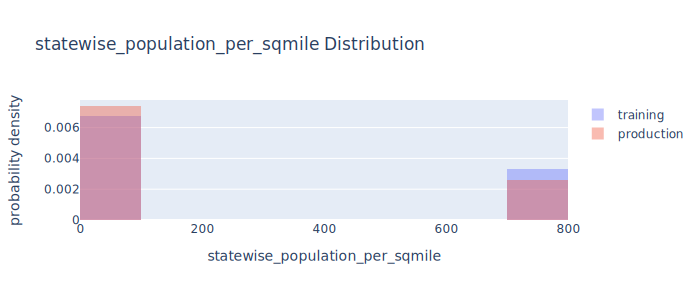

10:53:55 INFO:drift detected for warehouse_ID.value
10:53:55 INFO:drift_score : 1.2165486125703978e-13
10:53:55 INFO:stattest_name : chi-square p_value
10:53:55 INFO:raw_feature_importance : 0.34772932529449463
10:53:55 INFO:relative_feature_importance : 0.1511020064353943
10:53:55 INFO:feature_importance_weighted_drift_score : 8.051174443474711e-13


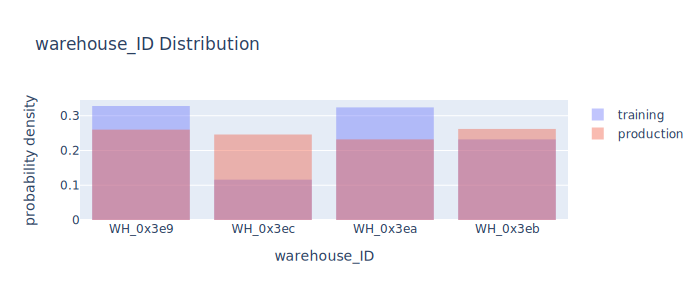

10:53:55 INFO:drift detected for Product_Type.value
10:53:55 INFO:drift_score : 0.00035027264131759495
10:53:55 INFO:stattest_name : Z-test p_value
10:53:55 INFO:raw_feature_importance : 2.301288604736328
10:53:55 INFO:relative_feature_importance : 1.0
10:53:55 INFO:feature_importance_weighted_drift_score : 0.00035027264131759495


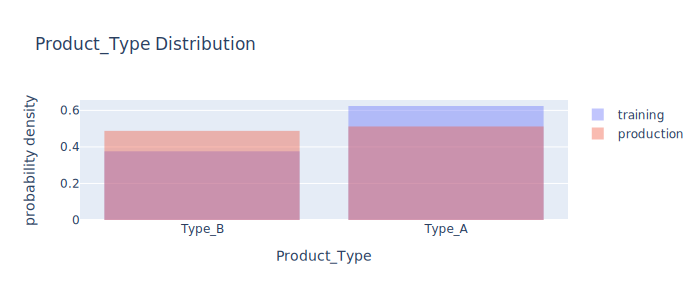

True

In [67]:
test_mlflow(experiment_name = 'mlflow drift detection test', run_name=str(int(time.mktime(datetime.now().timetuple()))))

#### Simulate model on data from 2019-04-01 to 2020-11-15

In [72]:
simulate_df = df[df.date >= datetime(2019,3,1)]

In [73]:
@mlflow_runner
def simulate_Weekly_experiment(df, preds, experiment_name, run_name, week_num,plot_display =False):
    # Get weekly data
        global final_X_transform
        global final_y
        global reg_final
        row = df.iloc[0]
        dt = row['date']
        start = dt - timedelta(days=row['date'].weekday())
        end = start + timedelta(days=6)
        sub_df = df.set_index('date')[start:end]
        sub_df = sub_df.reset_index().set_index('ID')
        df = df[(df.date.dt.date > end.date())]
        print(f'Experiment week {week_num}')
        print('---------------------------------')
        print(f"Experiment start date : {start.to_pydatetime()}")
        print(f"Experiment end_date : {end.to_pydatetime()}")
        mlflow.log_param('experiment_week',week_num)
        mlflow.log_param('week_begin_experiment_start_date',start)
        mlflow.log_param('week_end_experiment_end_date',end)
        
        # Transform sub_df to X, y
        X_prod,y_prod = split_features_target(sub_df)
        X_prod_transformed = ht.transform(X_prod)
        
        mlflow.log_dict(X_prod_transformed.to_dict(), 'input_features.json')
        mlflow.log_dict(y_prod.to_dict(), 'target.json')
        # weekly_prediction
        weekly_predictions = reg_final.predict(X_prod_transformed)
        
        mlflow.log_dict(pd.Series(weekly_predictions,name=y_prod.name, index = y_prod.index).to_dict(),'weekly_predictions.json')
        # Predict for X,y
        scores_dict = get_scores(y_prod,weekly_predictions,f"weekly")
        mlflow.log_metrics(scores_dict)
        preds.extend(weekly_predictions.tolist())
        ht.fit(X_prod)
        #reference_data = final_X_transform.sample(n = X_prod_transformed.shape[0])
        #reference_target = final_y.loc[final_y.index.isin(reference_data.index)].reindex(reference_data.index)
        
        if test_for_drift(final_X_transform, final_y, X_prod_transformed, y_prod, reg_final, plot_display, mlflow_log=True):
            # retrain model
            # test for drift an
            logging.info('Retraining model')
            reg_final.fit(X_prod_transformed, y_prod)
        else:
            logging.info('No Drift detection')
        final_X_transform = final_X_transform.append(X_prod_transformed)
        final_y = final_y.append(y_prod)
        print(final_X_transform.shape)
        print(final_y.shape)
        return df, preds

In [70]:
def simulate_model(df, experiment_name, run_name, plot_display =False):
    
    preds = []
    df = df.reset_index()
    current_df = df
    month_num = 1
    while current_df.shape[0] > 0:

        current_df, preds = simulate_monthly_experiment(current_df, preds, experiment_name = experiment_name,  run_name=run_name,
        month_num=month_num, plot_display = plot_display)
        month_num +=1
    return preds   

In [74]:
preds = simulate_model(simulate_df, experiment_name='monthly_ml_monitoring', run_name=str(int(time.mktime(datetime.now().timetuple()))))

2022/07/14 11:22:59 INFO mlflow.tracking.fluent: Experiment with name 'monthly_ml_monitoring' does not exist. Creating a new experiment.


Experiment week 1
---------------------------------
Experiment start date : 2019-02-25 00:00:00
Experiment end_date : 2019-03-03 00:00:00


11:22:59 INFO:target drift detect: True
11:23:00 INFO:drift not detected
11:23:00 INFO:Retraining model


(4022, 31)
(4022,)
Experiment week 2
---------------------------------
Experiment start date : 2019-03-04 00:00:00
Experiment end_date : 2019-03-10 00:00:00


11:23:00 INFO:target drift detect: True
11:23:00 INFO:data set drift detected
11:23:01 INFO:drift detected for Product_Type.value
11:23:01 INFO:drift_score : 0.8325546111576977
11:23:01 INFO:stattest_name : Jensen-Shannon distance
11:23:01 INFO:raw_feature_importance : 2.193288564682007
11:23:01 INFO:relative_feature_importance : 1.0
11:23:01 INFO:feature_importance_weighted_drift_score : 0.8325546111576977
11:23:01 INFO:Retraining model


(4092, 31)
(4092,)
Experiment week 3
---------------------------------
Experiment start date : 2019-03-11 00:00:00
Experiment end_date : 2019-03-17 00:00:00


11:23:03 INFO:target drift detect: True
11:23:03 INFO:data set drift detected
11:23:03 INFO:drift detected for Product_Type.value
11:23:03 INFO:drift_score : 0.8060545427663132
11:23:03 INFO:stattest_name : Jensen-Shannon distance
11:23:03 INFO:raw_feature_importance : 2.0501251220703125
11:23:03 INFO:relative_feature_importance : 1.0
11:23:03 INFO:feature_importance_weighted_drift_score : 0.8060545427663132
11:23:04 INFO:Retraining model


(4162, 31)
(4162,)
Experiment week 4
---------------------------------
Experiment start date : 2019-03-18 00:00:00
Experiment end_date : 2019-03-24 00:00:00


11:23:05 INFO:target drift detect: True
11:23:05 INFO:data set drift detected
11:23:06 INFO:drift detected for Product_Type.value
11:23:06 INFO:drift_score : 0.7867637942388346
11:23:06 INFO:stattest_name : Jensen-Shannon distance
11:23:06 INFO:raw_feature_importance : 2.158252477645874
11:23:06 INFO:relative_feature_importance : 1.0
11:23:06 INFO:feature_importance_weighted_drift_score : 0.7867637942388346
11:23:06 INFO:Retraining model


(4232, 31)
(4232,)
Experiment week 5
---------------------------------
Experiment start date : 2019-03-25 00:00:00
Experiment end_date : 2019-03-31 00:00:00


11:23:07 INFO:target drift detect: True
11:23:07 INFO:data set drift detected
11:23:08 INFO:drift detected for Product_Type.value
11:23:08 INFO:drift_score : 0.7702046767484584
11:23:08 INFO:stattest_name : Jensen-Shannon distance
11:23:08 INFO:raw_feature_importance : 1.9569185972213745
11:23:08 INFO:relative_feature_importance : 1.0
11:23:08 INFO:feature_importance_weighted_drift_score : 0.7702046767484584
11:23:08 INFO:Retraining model


(4302, 31)
(4302,)
Experiment week 6
---------------------------------
Experiment start date : 2019-04-01 00:00:00
Experiment end_date : 2019-04-07 00:00:00


11:23:10 INFO:target drift detect: True
11:23:10 INFO:data set drift detected
11:23:11 INFO:drift detected for Product_Type.value
11:23:11 INFO:drift_score : 0.7554193633815949
11:23:11 INFO:stattest_name : Jensen-Shannon distance
11:23:11 INFO:raw_feature_importance : 2.2027387619018555
11:23:11 INFO:relative_feature_importance : 1.0
11:23:11 INFO:feature_importance_weighted_drift_score : 0.7554193633815949
11:23:11 INFO:Retraining model


(4372, 31)
(4372,)
Experiment week 7
---------------------------------
Experiment start date : 2019-04-08 00:00:00
Experiment end_date : 2019-04-14 00:00:00


11:23:14 INFO:target drift detect: False
11:23:14 INFO:data set drift detected
11:23:15 INFO:drift detected for Product_Type.value
11:23:15 INFO:drift_score : 0.7419485455515465
11:23:15 INFO:stattest_name : Jensen-Shannon distance
11:23:15 INFO:raw_feature_importance : 2.483466386795044
11:23:15 INFO:relative_feature_importance : 1.0
11:23:15 INFO:feature_importance_weighted_drift_score : 0.7419485455515465
11:23:15 INFO:Retraining model


(4442, 31)
(4442,)
Experiment week 8
---------------------------------
Experiment start date : 2019-04-15 00:00:00
Experiment end_date : 2019-04-21 00:00:00


11:23:18 INFO:target drift detect: True
11:23:18 INFO:data set drift detected
11:23:18 INFO:drift detected for Product_Type.value
11:23:18 INFO:drift_score : 0.7295190331766476
11:23:18 INFO:stattest_name : Jensen-Shannon distance
11:23:18 INFO:raw_feature_importance : 2.3496620655059814
11:23:18 INFO:relative_feature_importance : 1.0
11:23:18 INFO:feature_importance_weighted_drift_score : 0.7295190331766476
11:23:19 INFO:Retraining model


(4512, 31)
(4512,)
Experiment week 9
---------------------------------
Experiment start date : 2019-04-22 00:00:00
Experiment end_date : 2019-04-28 00:00:00


11:23:21 INFO:target drift detect: True
11:23:21 INFO:data set drift detected
11:23:22 INFO:drift detected for Product_Type.value
11:23:22 INFO:drift_score : 0.7179486416460911
11:23:22 INFO:stattest_name : Jensen-Shannon distance
11:23:22 INFO:raw_feature_importance : 2.249964952468872
11:23:22 INFO:relative_feature_importance : 1.0
11:23:22 INFO:feature_importance_weighted_drift_score : 0.7179486416460911
11:23:22 INFO:Retraining model


(4582, 31)
(4582,)
Experiment week 10
---------------------------------
Experiment start date : 2019-04-29 00:00:00
Experiment end_date : 2019-05-05 00:00:00


11:23:23 INFO:target drift detect: True
11:23:23 INFO:data set drift detected
11:23:24 INFO:drift detected for Product_Type.value
11:23:24 INFO:drift_score : 0.7071068064697682
11:23:24 INFO:stattest_name : Jensen-Shannon distance
11:23:24 INFO:raw_feature_importance : 2.6990270614624023
11:23:24 INFO:relative_feature_importance : 1.0
11:23:24 INFO:feature_importance_weighted_drift_score : 0.7071068064697682
11:23:24 INFO:Retraining model


(4660, 31)
(4660,)
Experiment week 11
---------------------------------
Experiment start date : 2019-05-06 00:00:00
Experiment end_date : 2019-05-12 00:00:00


11:23:26 INFO:target drift detect: True
11:23:26 INFO:data set drift detected
11:23:27 INFO:drift detected for Product_Type.value
11:23:27 INFO:drift_score : 0.6957646668148844
11:23:27 INFO:stattest_name : Jensen-Shannon distance
11:23:27 INFO:raw_feature_importance : 2.5503623485565186
11:23:27 INFO:relative_feature_importance : 1.0
11:23:27 INFO:feature_importance_weighted_drift_score : 0.6957646668148844
11:23:27 INFO:Retraining model


(4744, 31)
(4744,)
Experiment week 12
---------------------------------
Experiment start date : 2019-05-13 00:00:00
Experiment end_date : 2019-05-19 00:00:00


11:23:28 INFO:target drift detect: True
11:23:29 INFO:data set drift detected
11:23:29 INFO:drift detected for Product_Type.value
11:23:29 INFO:drift_score : 0.6843057225852544
11:23:29 INFO:stattest_name : Jensen-Shannon distance
11:23:29 INFO:raw_feature_importance : 2.596639633178711
11:23:29 INFO:relative_feature_importance : 1.0
11:23:29 INFO:feature_importance_weighted_drift_score : 0.6843057225852544
11:23:30 INFO:Retraining model


(4828, 31)
(4828,)
Experiment week 13
---------------------------------
Experiment start date : 2019-05-20 00:00:00
Experiment end_date : 2019-05-26 00:00:00


11:23:31 INFO:target drift detect: False
11:23:32 INFO:data set drift detected
11:23:32 INFO:drift detected for Product_Type.value
11:23:32 INFO:drift_score : 0.6735310398648455
11:23:32 INFO:stattest_name : Jensen-Shannon distance
11:23:32 INFO:raw_feature_importance : 2.5374693870544434
11:23:32 INFO:relative_feature_importance : 1.0
11:23:32 INFO:feature_importance_weighted_drift_score : 0.6735310398648455
11:23:33 INFO:Retraining model


(4912, 31)
(4912,)
Experiment week 14
---------------------------------
Experiment start date : 2019-05-27 00:00:00
Experiment end_date : 2019-06-02 00:00:00


11:23:35 INFO:target drift detect: True
11:23:35 INFO:data set drift detected
11:23:35 INFO:drift detected for Product_Type.value
11:23:35 INFO:drift_score : 0.6633593952999148
11:23:35 INFO:stattest_name : Jensen-Shannon distance
11:23:35 INFO:raw_feature_importance : 2.295356035232544
11:23:35 INFO:relative_feature_importance : 1.0
11:23:35 INFO:feature_importance_weighted_drift_score : 0.6633593952999148
11:23:36 INFO:Retraining model


(4996, 31)
(4996,)
Experiment week 15
---------------------------------
Experiment start date : 2019-06-03 00:00:00
Experiment end_date : 2019-06-09 00:00:00


11:23:37 INFO:target drift detect: True
11:23:37 INFO:data set drift detected
11:23:38 INFO:drift detected for Product_Type.value
11:23:38 INFO:drift_score : 0.6537247661727477
11:23:38 INFO:stattest_name : Jensen-Shannon distance
11:23:38 INFO:raw_feature_importance : 2.56994366645813
11:23:38 INFO:relative_feature_importance : 1.0
11:23:38 INFO:feature_importance_weighted_drift_score : 0.6537247661727477
11:23:38 INFO:Retraining model


(5080, 31)
(5080,)
Experiment week 16
---------------------------------
Experiment start date : 2019-06-10 00:00:00
Experiment end_date : 2019-06-16 00:00:00


11:23:40 INFO:target drift detect: True
11:23:40 INFO:data set drift detected
11:23:41 INFO:drift detected for Product_Type.value
11:23:41 INFO:drift_score : 0.6445724612298418
11:23:41 INFO:stattest_name : Jensen-Shannon distance
11:23:41 INFO:raw_feature_importance : 2.5322442054748535
11:23:41 INFO:relative_feature_importance : 1.0
11:23:41 INFO:feature_importance_weighted_drift_score : 0.6445724612298418
11:23:41 INFO:Retraining model


(5164, 31)
(5164,)
Experiment week 17
---------------------------------
Experiment start date : 2019-06-17 00:00:00
Experiment end_date : 2019-06-23 00:00:00


11:23:45 INFO:target drift detect: True
11:23:45 INFO:data set drift detected
11:23:46 INFO:drift detected for Product_Type.value
11:23:46 INFO:drift_score : 0.635856469676383
11:23:46 INFO:stattest_name : Jensen-Shannon distance
11:23:46 INFO:raw_feature_importance : 2.4850659370422363
11:23:46 INFO:relative_feature_importance : 1.0
11:23:46 INFO:feature_importance_weighted_drift_score : 0.635856469676383
11:23:46 INFO:Retraining model


(5248, 31)
(5248,)
Experiment week 18
---------------------------------
Experiment start date : 2019-06-24 00:00:00
Experiment end_date : 2019-06-30 00:00:00


11:23:48 INFO:target drift detect: True
11:23:48 INFO:data set drift detected
11:23:49 INFO:drift detected for Product_Type.value
11:23:49 INFO:drift_score : 0.6275375813368586
11:23:49 INFO:stattest_name : Jensen-Shannon distance
11:23:49 INFO:raw_feature_importance : 2.4968647956848145
11:23:49 INFO:relative_feature_importance : 1.0
11:23:49 INFO:feature_importance_weighted_drift_score : 0.6275375813368586
11:23:49 INFO:Retraining model


(5332, 31)
(5332,)
Experiment week 19
---------------------------------
Experiment start date : 2019-07-01 00:00:00
Experiment end_date : 2019-07-07 00:00:00


11:23:51 INFO:target drift detect: True
11:23:51 INFO:data set drift detected
11:23:51 INFO:drift detected for Product_Type.value
11:23:51 INFO:drift_score : 0.6195820150555587
11:23:51 INFO:stattest_name : Jensen-Shannon distance
11:23:51 INFO:raw_feature_importance : 2.901125192642212
11:23:51 INFO:relative_feature_importance : 1.0
11:23:51 INFO:feature_importance_weighted_drift_score : 0.6195820150555587
11:23:52 INFO:Retraining model


(5416, 31)
(5416,)
Experiment week 20
---------------------------------
Experiment start date : 2019-07-08 00:00:00
Experiment end_date : 2019-07-14 00:00:00


11:23:53 INFO:target drift detect: True
11:23:53 INFO:data set drift detected
11:23:54 INFO:drift detected for Product_Type.value
11:23:54 INFO:drift_score : 0.6119603935263707
11:23:54 INFO:stattest_name : Jensen-Shannon distance
11:23:54 INFO:raw_feature_importance : 2.8008570671081543
11:23:54 INFO:relative_feature_importance : 1.0
11:23:54 INFO:feature_importance_weighted_drift_score : 0.6119603935263707
11:23:54 INFO:Retraining model


(5500, 31)
(5500,)
Experiment week 21
---------------------------------
Experiment start date : 2019-07-15 00:00:00
Experiment end_date : 2019-07-21 00:00:00


11:23:55 INFO:target drift detect: True
11:23:56 INFO:data set drift detected
11:23:56 INFO:drift detected for Product_Type.value
11:23:56 INFO:drift_score : 0.6046469611083302
11:23:56 INFO:stattest_name : Jensen-Shannon distance
11:23:56 INFO:raw_feature_importance : 3.0304081439971924
11:23:56 INFO:relative_feature_importance : 1.0
11:23:56 INFO:feature_importance_weighted_drift_score : 0.6046469611083302
11:23:57 INFO:Retraining model


(5584, 31)
(5584,)
Experiment week 22
---------------------------------
Experiment start date : 2019-07-22 00:00:00
Experiment end_date : 2019-07-28 00:00:00


11:24:00 INFO:target drift detect: True
11:24:01 INFO:data set drift detected
11:24:01 INFO:drift detected for Product_Type.value
11:24:01 INFO:drift_score : 0.5976189763145171
11:24:01 INFO:stattest_name : Jensen-Shannon distance
11:24:01 INFO:raw_feature_importance : 3.036762237548828
11:24:01 INFO:relative_feature_importance : 1.0
11:24:01 INFO:feature_importance_weighted_drift_score : 0.5976189763145171
11:24:02 INFO:Retraining model


(5668, 31)
(5668,)
Experiment week 23
---------------------------------
Experiment start date : 2019-07-29 00:00:00
Experiment end_date : 2019-08-04 00:00:00


11:24:03 INFO:target drift detect: True
11:24:03 INFO:data set drift detected
11:24:04 INFO:drift detected for Product_Type.value
11:24:04 INFO:drift_score : 0.5908562325790003
11:24:04 INFO:stattest_name : Jensen-Shannon distance
11:24:04 INFO:raw_feature_importance : 2.738304853439331
11:24:04 INFO:relative_feature_importance : 1.0
11:24:04 INFO:feature_importance_weighted_drift_score : 0.5908562325790003
11:24:04 INFO:Retraining model


(5752, 31)
(5752,)
Experiment week 24
---------------------------------
Experiment start date : 2019-08-05 00:00:00
Experiment end_date : 2019-08-11 00:00:00


11:24:06 INFO:target drift detect: False
11:24:06 INFO:data set drift detected
11:24:07 INFO:drift detected for Product_Type.value
11:24:07 INFO:drift_score : 0.5843406750113375
11:24:07 INFO:stattest_name : Jensen-Shannon distance
11:24:07 INFO:raw_feature_importance : 2.48544979095459
11:24:07 INFO:relative_feature_importance : 1.0
11:24:07 INFO:feature_importance_weighted_drift_score : 0.5843406750113375
11:24:07 INFO:Retraining model


(5836, 31)
(5836,)
Experiment week 25
---------------------------------
Experiment start date : 2019-08-12 00:00:00
Experiment end_date : 2019-08-18 00:00:00


11:24:09 INFO:target drift detect: True
11:24:09 INFO:data set drift detected
11:24:09 INFO:drift detected for Product_Type.value
11:24:09 INFO:drift_score : 0.5780560901755926
11:24:09 INFO:stattest_name : Jensen-Shannon distance
11:24:09 INFO:raw_feature_importance : 2.433576822280884
11:24:09 INFO:relative_feature_importance : 1.0
11:24:09 INFO:feature_importance_weighted_drift_score : 0.5780560901755926
11:24:10 INFO:Retraining model


(5920, 31)
(5920,)
Experiment week 26
---------------------------------
Experiment start date : 2019-08-19 00:00:00
Experiment end_date : 2019-08-25 00:00:00


11:24:12 INFO:target drift detect: False
11:24:13 INFO:data set drift detected
11:24:13 INFO:drift detected for Product_Type.value
11:24:13 INFO:drift_score : 0.5719878522489589
11:24:13 INFO:stattest_name : Jensen-Shannon distance
11:24:13 INFO:raw_feature_importance : 2.361478090286255
11:24:13 INFO:relative_feature_importance : 1.0
11:24:13 INFO:feature_importance_weighted_drift_score : 0.5719878522489589
11:24:13 INFO:Retraining model


(6004, 31)
(6004,)
Experiment week 27
---------------------------------
Experiment start date : 2019-08-26 00:00:00
Experiment end_date : 2019-09-01 00:00:00


11:24:15 INFO:target drift detect: False
11:24:15 INFO:data set drift detected
11:24:15 INFO:drift detected for Product_Type.value
11:24:15 INFO:drift_score : 0.5661227132872191
11:24:15 INFO:stattest_name : Jensen-Shannon distance
11:24:15 INFO:raw_feature_importance : 2.460589647293091
11:24:15 INFO:relative_feature_importance : 1.0
11:24:15 INFO:feature_importance_weighted_drift_score : 0.5661227132872191
11:24:16 INFO:Retraining model


(6088, 31)
(6088,)
Experiment week 28
---------------------------------
Experiment start date : 2019-09-02 00:00:00
Experiment end_date : 2019-09-08 00:00:00


11:24:18 INFO:target drift detect: False
11:24:18 INFO:data set drift detected
11:24:19 INFO:drift detected for Product_Type.value
11:24:19 INFO:drift_score : 0.5604486284082165
11:24:19 INFO:stattest_name : Jensen-Shannon distance
11:24:19 INFO:raw_feature_importance : 2.2670881748199463
11:24:19 INFO:relative_feature_importance : 1.0
11:24:19 INFO:feature_importance_weighted_drift_score : 0.5604486284082165
11:24:19 INFO:Retraining model


(6172, 31)
(6172,)
Experiment week 29
---------------------------------
Experiment start date : 2019-09-09 00:00:00
Experiment end_date : 2019-09-15 00:00:00


11:24:21 INFO:target drift detect: False
11:24:21 INFO:data set drift detected
11:24:21 INFO:drift detected for Product_Type.value
11:24:21 INFO:drift_score : 0.5549546089176464
11:24:21 INFO:stattest_name : Jensen-Shannon distance
11:24:21 INFO:raw_feature_importance : 2.366988182067871
11:24:21 INFO:relative_feature_importance : 1.0
11:24:21 INFO:feature_importance_weighted_drift_score : 0.5549546089176464
11:24:22 INFO:Retraining model


(6256, 31)
(6256,)
Experiment week 30
---------------------------------
Experiment start date : 2019-09-16 00:00:00
Experiment end_date : 2019-09-22 00:00:00


11:24:23 INFO:target drift detect: False
11:24:23 INFO:data set drift detected
11:24:24 INFO:drift detected for Product_Type.value
11:24:24 INFO:drift_score : 0.5496305980146298
11:24:24 INFO:stattest_name : Jensen-Shannon distance
11:24:24 INFO:raw_feature_importance : 2.3027725219726562
11:24:24 INFO:relative_feature_importance : 1.0
11:24:24 INFO:feature_importance_weighted_drift_score : 0.5496305980146298
11:24:24 INFO:Retraining model


(6340, 31)
(6340,)
Experiment week 31
---------------------------------
Experiment start date : 2019-09-23 00:00:00
Experiment end_date : 2019-09-29 00:00:00


11:24:26 INFO:target drift detect: False
11:24:26 INFO:data set drift detected
11:24:26 INFO:drift detected for Product_Type.value
11:24:26 INFO:drift_score : 0.5444673649071998
11:24:26 INFO:stattest_name : Jensen-Shannon distance
11:24:26 INFO:raw_feature_importance : 2.18032169342041
11:24:26 INFO:relative_feature_importance : 1.0
11:24:26 INFO:feature_importance_weighted_drift_score : 0.5444673649071998
11:24:27 INFO:Retraining model


(6424, 31)
(6424,)
Experiment week 32
---------------------------------
Experiment start date : 2019-09-30 00:00:00
Experiment end_date : 2019-10-06 00:00:00


11:24:28 INFO:target drift detect: True
11:24:28 INFO:data set drift detected
11:24:29 INFO:drift detected for Product_Type.value
11:24:29 INFO:drift_score : 0.5394564140610963
11:24:29 INFO:stattest_name : Jensen-Shannon distance
11:24:29 INFO:raw_feature_importance : 2.314099073410034
11:24:29 INFO:relative_feature_importance : 1.0
11:24:29 INFO:feature_importance_weighted_drift_score : 0.5394564140610963
11:24:29 INFO:Retraining model


(6508, 31)
(6508,)
Experiment week 33
---------------------------------
Experiment start date : 2019-10-07 00:00:00
Experiment end_date : 2019-10-13 00:00:00


11:24:31 INFO:target drift detect: True
11:24:31 INFO:data set drift detected
11:24:31 INFO:drift detected for Product_Type.value
11:24:31 INFO:drift_score : 0.5345899069822945
11:24:31 INFO:stattest_name : Jensen-Shannon distance
11:24:31 INFO:raw_feature_importance : 2.3092122077941895
11:24:31 INFO:relative_feature_importance : 1.0
11:24:31 INFO:feature_importance_weighted_drift_score : 0.5345899069822945
11:24:32 INFO:Retraining model


(6592, 31)
(6592,)
Experiment week 34
---------------------------------
Experiment start date : 2019-10-14 00:00:00
Experiment end_date : 2019-10-20 00:00:00


11:24:33 INFO:target drift detect: True
11:24:33 INFO:data set drift detected
11:24:33 INFO:drift detected for Product_Type.value
11:24:33 INFO:drift_score : 0.529860594452486
11:24:33 INFO:stattest_name : Jensen-Shannon distance
11:24:33 INFO:raw_feature_importance : 2.0150303840637207
11:24:33 INFO:relative_feature_importance : 1.0
11:24:33 INFO:feature_importance_weighted_drift_score : 0.529860594452486
11:24:34 INFO:Retraining model


(6676, 31)
(6676,)
Experiment week 35
---------------------------------
Experiment start date : 2019-10-21 00:00:00
Experiment end_date : 2019-10-27 00:00:00


11:24:35 INFO:target drift detect: True
11:24:35 INFO:data set drift detected
11:24:36 INFO:drift detected for warehouse_ID.value
11:24:36 INFO:drift_score : 0.5914921920924988
11:24:36 INFO:stattest_name : Jensen-Shannon distance
11:24:36 INFO:raw_feature_importance : 0.37373003363609314
11:24:36 INFO:relative_feature_importance : 0.18184258043766022
11:24:36 INFO:feature_importance_weighted_drift_score : 0.10755846651882818
11:24:36 INFO:drift detected for Product_Type.value
11:24:36 INFO:drift_score : 0.525261757538282
11:24:36 INFO:stattest_name : Jensen-Shannon distance
11:24:36 INFO:raw_feature_importance : 2.05523943901062
11:24:36 INFO:relative_feature_importance : 1.0
11:24:36 INFO:feature_importance_weighted_drift_score : 0.525261757538282
11:24:36 INFO:Retraining model


(6760, 31)
(6760,)
Experiment week 36
---------------------------------
Experiment start date : 2019-10-28 00:00:00
Experiment end_date : 2019-11-03 00:00:00


11:24:40 INFO:target drift detect: True
11:24:40 INFO:data set drift detected
11:24:40 INFO:drift detected for Product_Type.value
11:24:40 INFO:drift_score : 0.5207871560086539
11:24:40 INFO:stattest_name : Jensen-Shannon distance
11:24:40 INFO:raw_feature_importance : 2.206885814666748
11:24:40 INFO:relative_feature_importance : 1.0
11:24:40 INFO:feature_importance_weighted_drift_score : 0.5207871560086539
11:24:41 INFO:Retraining model


(6844, 31)
(6844,)
Experiment week 37
---------------------------------
Experiment start date : 2019-11-04 00:00:00
Experiment end_date : 2019-11-10 00:00:00


11:24:43 INFO:target drift detect: True
11:24:44 INFO:data set drift detected
11:24:44 INFO:drift detected for Product_Type.value
11:24:44 INFO:drift_score : 0.5164309830423907
11:24:44 INFO:stattest_name : Jensen-Shannon distance
11:24:44 INFO:raw_feature_importance : 2.2605092525482178
11:24:44 INFO:relative_feature_importance : 1.0
11:24:44 INFO:feature_importance_weighted_drift_score : 0.5164309830423907
11:24:45 INFO:Retraining model


(6928, 31)
(6928,)
Experiment week 38
---------------------------------
Experiment start date : 2019-11-11 00:00:00
Experiment end_date : 2019-11-17 00:00:00


11:24:47 INFO:target drift detect: False
11:24:47 INFO:data set drift detected
11:24:47 INFO:drift detected for Product_Type.value
11:24:47 INFO:drift_score : 0.5121878253037974
11:24:47 INFO:stattest_name : Jensen-Shannon distance
11:24:47 INFO:raw_feature_importance : 2.4199869632720947
11:24:47 INFO:relative_feature_importance : 1.0
11:24:47 INFO:feature_importance_weighted_drift_score : 0.5121878253037974
11:24:48 INFO:Retraining model


(7012, 31)
(7012,)
Experiment week 39
---------------------------------
Experiment start date : 2019-11-18 00:00:00
Experiment end_date : 2019-11-24 00:00:00


11:24:49 INFO:target drift detect: False
11:24:49 INFO:data set drift detected
11:24:49 INFO:drift detected for Product_Type.value
11:24:49 INFO:drift_score : 0.5080526276221318
11:24:49 INFO:stattest_name : Jensen-Shannon distance
11:24:49 INFO:raw_feature_importance : 2.2703731060028076
11:24:49 INFO:relative_feature_importance : 1.0
11:24:49 INFO:feature_importance_weighted_drift_score : 0.5080526276221318
11:24:50 INFO:Retraining model


(7096, 31)
(7096,)
Experiment week 40
---------------------------------
Experiment start date : 2019-11-25 00:00:00
Experiment end_date : 2019-12-01 00:00:00


11:24:51 INFO:target drift detect: True
11:24:51 INFO:data set drift detected
11:24:52 INFO:drift detected for Product_Type.value
11:24:52 INFO:drift_score : 0.5040206616370503
11:24:52 INFO:stattest_name : Jensen-Shannon distance
11:24:52 INFO:raw_feature_importance : 2.4322173595428467
11:24:52 INFO:relative_feature_importance : 1.0
11:24:52 INFO:feature_importance_weighted_drift_score : 0.5040206616370503
11:24:52 INFO:Retraining model


(7180, 31)
(7180,)
Experiment week 41
---------------------------------
Experiment start date : 2019-12-02 00:00:00
Experiment end_date : 2019-12-08 00:00:00


11:24:54 INFO:target drift detect: True
11:24:54 INFO:data set drift detected
11:24:54 INFO:drift detected for Product_Type.value
11:24:54 INFO:drift_score : 0.5000874978752199
11:24:54 INFO:stattest_name : Jensen-Shannon distance
11:24:54 INFO:raw_feature_importance : 2.0557711124420166
11:24:54 INFO:relative_feature_importance : 1.0
11:24:54 INFO:feature_importance_weighted_drift_score : 0.5000874978752199
11:24:55 INFO:Retraining model


(7264, 31)
(7264,)
Experiment week 42
---------------------------------
Experiment start date : 2019-12-09 00:00:00
Experiment end_date : 2019-12-15 00:00:00


11:24:56 INFO:target drift detect: True
11:24:56 INFO:data set drift detected
11:24:57 INFO:drift detected for Product_Type.value
11:24:57 INFO:drift_score : 0.49624898080726704
11:24:57 INFO:stattest_name : Jensen-Shannon distance
11:24:57 INFO:raw_feature_importance : 1.6530424356460571
11:24:57 INFO:relative_feature_importance : 1.0
11:24:57 INFO:feature_importance_weighted_drift_score : 0.49624898080726704
11:24:57 INFO:Retraining model


(7348, 31)
(7348,)
Experiment week 43
---------------------------------
Experiment start date : 2019-12-16 00:00:00
Experiment end_date : 2019-12-22 00:00:00


11:24:59 INFO:target drift detect: True
11:25:00 INFO:data set drift detected
11:25:00 INFO:drift detected for Product_Type.value
11:25:00 INFO:drift_score : 0.49250120650323276
11:25:00 INFO:stattest_name : Jensen-Shannon distance
11:25:00 INFO:raw_feature_importance : 1.7424237728118896
11:25:00 INFO:relative_feature_importance : 1.0
11:25:00 INFO:feature_importance_weighted_drift_score : 0.49250120650323276
11:25:01 INFO:Retraining model


(7432, 31)
(7432,)
Experiment week 44
---------------------------------
Experiment start date : 2019-12-23 00:00:00
Experiment end_date : 2019-12-29 00:00:00


11:25:03 INFO:target drift detect: True
11:25:04 INFO:data set drift detected
11:25:04 INFO:drift detected for Product_Type.value
11:25:04 INFO:drift_score : 0.4888405025616896
11:25:04 INFO:stattest_name : Jensen-Shannon distance
11:25:04 INFO:raw_feature_importance : 1.7624571323394775
11:25:04 INFO:relative_feature_importance : 1.0
11:25:04 INFO:feature_importance_weighted_drift_score : 0.4888405025616896
11:25:04 INFO:Retraining model


(7516, 31)
(7516,)
Experiment week 45
---------------------------------
Experiment start date : 2019-12-30 00:00:00
Experiment end_date : 2020-01-05 00:00:00


11:25:07 INFO:target drift detect: True
11:25:07 INFO:data set drift detected
11:25:08 INFO:drift detected for Product_Type.value
11:25:08 INFO:drift_score : 0.4852634100349826
11:25:08 INFO:stattest_name : Jensen-Shannon distance
11:25:08 INFO:raw_feature_importance : 1.4919816255569458
11:25:08 INFO:relative_feature_importance : 1.0
11:25:08 INFO:feature_importance_weighted_drift_score : 0.4852634100349826
11:25:08 INFO:Retraining model


(7608, 31)
(7608,)
Experiment week 46
---------------------------------
Experiment start date : 2020-01-06 00:00:00
Experiment end_date : 2020-01-12 00:00:00


11:25:11 INFO:target drift detect: True
11:25:12 INFO:data set drift detected
11:25:12 INFO:drift detected for Product_Type.value
11:25:12 INFO:drift_score : 0.48143772094478526
11:25:12 INFO:stattest_name : Jensen-Shannon distance
11:25:12 INFO:raw_feature_importance : 1.5941250324249268
11:25:12 INFO:relative_feature_importance : 1.0
11:25:12 INFO:feature_importance_weighted_drift_score : 0.48143772094478526
11:25:13 INFO:Retraining model


(7706, 31)
(7706,)
Experiment week 47
---------------------------------
Experiment start date : 2020-01-13 00:00:00
Experiment end_date : 2020-01-19 00:00:00


11:25:14 INFO:target drift detect: True
11:25:14 INFO:data set drift detected
11:25:15 INFO:drift detected for Product_Type.value
11:25:15 INFO:drift_score : 0.47746402069154176
11:25:15 INFO:stattest_name : Jensen-Shannon distance
11:25:15 INFO:raw_feature_importance : 1.683242917060852
11:25:15 INFO:relative_feature_importance : 1.0
11:25:15 INFO:feature_importance_weighted_drift_score : 0.47746402069154176
11:25:15 INFO:Retraining model


(7804, 31)
(7804,)
Experiment week 48
---------------------------------
Experiment start date : 2020-01-20 00:00:00
Experiment end_date : 2020-01-26 00:00:00


11:25:17 INFO:target drift detect: True
11:25:18 INFO:data set drift detected
11:25:18 INFO:drift detected for Product_Type.value
11:25:18 INFO:drift_score : 0.4735905369579477
11:25:18 INFO:stattest_name : Jensen-Shannon distance
11:25:18 INFO:raw_feature_importance : 1.5880743265151978
11:25:18 INFO:relative_feature_importance : 1.0
11:25:18 INFO:feature_importance_weighted_drift_score : 0.4735905369579477
11:25:18 INFO:Retraining model


(7902, 31)
(7902,)
Experiment week 49
---------------------------------
Experiment start date : 2020-01-27 00:00:00
Experiment end_date : 2020-02-02 00:00:00


11:25:20 INFO:target drift detect: True
11:25:20 INFO:data set drift detected
11:25:20 INFO:drift detected for Product_Type.value
11:25:20 INFO:drift_score : 0.4698129781172319
11:25:20 INFO:stattest_name : Jensen-Shannon distance
11:25:20 INFO:raw_feature_importance : 1.6035696268081665
11:25:20 INFO:relative_feature_importance : 1.0
11:25:20 INFO:feature_importance_weighted_drift_score : 0.4698129781172319
11:25:21 INFO:Retraining model


(8002, 31)
(8002,)
Experiment week 50
---------------------------------
Experiment start date : 2020-02-03 00:00:00
Experiment end_date : 2020-02-09 00:00:00


11:25:22 INFO:target drift detect: True
11:25:22 INFO:data set drift detected
11:25:23 INFO:drift detected for warehouse_ID.value
11:25:23 INFO:drift_score : 0.8325546111576977
11:25:23 INFO:stattest_name : Jensen-Shannon distance
11:25:23 INFO:raw_feature_importance : 0.2620079219341278
11:25:23 INFO:relative_feature_importance : 0.15556128323078156
11:25:23 INFO:feature_importance_weighted_drift_score : 0.12951326367139582
11:25:23 INFO:drift detected for Product_Type.value
11:25:23 INFO:drift_score : 0.46605302667537596
11:25:23 INFO:stattest_name : Jensen-Shannon distance
11:25:23 INFO:raw_feature_importance : 1.6842745542526245
11:25:23 INFO:relative_feature_importance : 1.0
11:25:23 INFO:feature_importance_weighted_drift_score : 0.46605302667537596
11:25:23 INFO:Retraining model


(8114, 31)
(8114,)
Experiment week 51
---------------------------------
Experiment start date : 2020-02-10 00:00:00
Experiment end_date : 2020-02-16 00:00:00


11:25:25 INFO:target drift detect: True
11:25:26 INFO:data set drift detected
11:25:26 INFO:drift detected for Product_Type.value
11:25:26 INFO:drift_score : 0.4619505202208473
11:25:26 INFO:stattest_name : Jensen-Shannon distance
11:25:26 INFO:raw_feature_importance : 1.7227860689163208
11:25:26 INFO:relative_feature_importance : 1.0
11:25:26 INFO:feature_importance_weighted_drift_score : 0.4619505202208473
11:25:27 INFO:Retraining model


(8226, 31)
(8226,)
Experiment week 52
---------------------------------
Experiment start date : 2020-02-17 00:00:00
Experiment end_date : 2020-02-23 00:00:00


11:25:30 INFO:target drift detect: True
11:25:30 INFO:data set drift detected
11:25:31 INFO:drift detected for Product_Type.value
11:25:31 INFO:drift_score : 0.4579577053991994
11:25:31 INFO:stattest_name : Jensen-Shannon distance
11:25:31 INFO:raw_feature_importance : 1.6459057331085205
11:25:31 INFO:relative_feature_importance : 1.0
11:25:31 INFO:feature_importance_weighted_drift_score : 0.4579577053991994
11:25:31 INFO:Retraining model


(8338, 31)
(8338,)
Experiment week 53
---------------------------------
Experiment start date : 2020-02-24 00:00:00
Experiment end_date : 2020-03-01 00:00:00


11:25:33 INFO:target drift detect: True
11:25:34 INFO:data set drift detected
11:25:34 INFO:drift detected for Product_Type.value
11:25:34 INFO:drift_score : 0.4540696323383307
11:25:34 INFO:stattest_name : Jensen-Shannon distance
11:25:34 INFO:raw_feature_importance : 1.8433468341827393
11:25:34 INFO:relative_feature_importance : 1.0
11:25:34 INFO:feature_importance_weighted_drift_score : 0.4540696323383307
11:25:34 INFO:Retraining model


(8450, 31)
(8450,)
Experiment week 54
---------------------------------
Experiment start date : 2020-03-02 00:00:00
Experiment end_date : 2020-03-08 00:00:00


11:25:37 INFO:target drift detect: True
11:25:38 INFO:data set drift detected
11:25:38 INFO:drift detected for state_cases.value
11:25:38 INFO:drift_score : 14.464802134028796
11:25:38 INFO:stattest_name : Wasserstein distance (normed)
11:25:38 INFO:raw_feature_importance : 0.1375526487827301
11:25:38 INFO:relative_feature_importance : 0.06835038214921951
11:25:38 INFO:feature_importance_weighted_drift_score : 0.9886747535737141
11:25:38 INFO:drift detected for Product_Type.value
11:25:38 INFO:drift_score : 0.4502816675757374
11:25:38 INFO:stattest_name : Jensen-Shannon distance
11:25:38 INFO:raw_feature_importance : 2.0124635696411133
11:25:38 INFO:relative_feature_importance : 1.0
11:25:38 INFO:feature_importance_weighted_drift_score : 0.4502816675757374
11:25:38 INFO:Retraining model


(8562, 31)
(8562,)
Experiment week 55
---------------------------------
Experiment start date : 2020-03-09 00:00:00
Experiment end_date : 2020-03-15 00:00:00


11:25:40 INFO:target drift detect: True
11:25:40 INFO:data set drift detected
11:25:41 INFO:drift detected for state_cases.value
11:25:41 INFO:drift_score : 50.022307083254994
11:25:41 INFO:stattest_name : Wasserstein distance (normed)
11:25:41 INFO:raw_feature_importance : 0.315552294254303
11:25:41 INFO:relative_feature_importance : 0.2524249255657196
11:25:41 INFO:feature_importance_weighted_drift_score : 12.62687714211621
11:25:41 INFO:drift detected for Product_Type.value
11:25:41 INFO:drift_score : 0.4465894677886207
11:25:41 INFO:stattest_name : Jensen-Shannon distance
11:25:41 INFO:raw_feature_importance : 1.2500836849212646
11:25:41 INFO:relative_feature_importance : 1.0
11:25:41 INFO:feature_importance_weighted_drift_score : 0.4465894677886207
11:25:41 INFO:Retraining model


(8674, 31)
(8674,)
Experiment week 56
---------------------------------
Experiment start date : 2020-03-16 00:00:00
Experiment end_date : 2020-03-22 00:00:00


11:25:43 INFO:target drift detect: True
11:25:44 INFO:data set drift detected
11:25:44 INFO:drift detected for state_cases.value
11:25:44 INFO:drift_score : 52.33781516230011
11:25:44 INFO:stattest_name : Wasserstein distance (normed)
11:25:44 INFO:raw_feature_importance : 0.09526854008436203
11:25:44 INFO:relative_feature_importance : 0.09667555242776871
11:25:44 INFO:feature_importance_weighted_drift_score : 5.0597871936778125
11:25:44 INFO:drift detected for state_deaths.value
11:25:44 INFO:drift_score : 22.00070228154435
11:25:44 INFO:stattest_name : Wasserstein distance (normed)
11:25:44 INFO:raw_feature_importance : 0.06549281626939774
11:25:44 INFO:relative_feature_importance : 0.06646007299423218
11:25:44 INFO:feature_importance_weighted_drift_score : 1.4621682795558077
11:25:45 INFO:drift detected for Product_Type.value
11:25:45 INFO:drift_score : 0.44298895621091267
11:25:45 INFO:stattest_name : Jensen-Shannon distance
11:25:45 INFO:raw_feature_importance : 0.985446035861969


(8786, 31)
(8786,)
Experiment week 57
---------------------------------
Experiment start date : 2020-03-23 00:00:00
Experiment end_date : 2020-03-29 00:00:00


11:25:46 INFO:target drift detect: True
11:25:47 INFO:data set drift detected
11:25:47 INFO:drift detected for state_cases.value
11:25:47 INFO:drift_score : 34.70612869335814
11:25:47 INFO:stattest_name : Wasserstein distance (normed)
11:25:47 INFO:raw_feature_importance : 0.2905508577823639
11:25:47 INFO:relative_feature_importance : 0.24120187759399414
11:25:47 INFO:feature_importance_weighted_drift_score : 8.371183404856778
11:25:47 INFO:drift detected for state_deaths.value
11:25:47 INFO:drift_score : 34.768310889306996
11:25:47 INFO:stattest_name : Wasserstein distance (normed)
11:25:47 INFO:raw_feature_importance : 0.10752590000629425
11:25:47 INFO:relative_feature_importance : 0.08926302939653397
11:25:47 INFO:feature_importance_weighted_drift_score : 3.1035247569800424
11:25:47 INFO:drift detected for Product_Type.value
11:25:47 INFO:drift_score : 0.4394763014107068
11:25:47 INFO:stattest_name : Jensen-Shannon distance
11:25:47 INFO:raw_feature_importance : 1.2045961618423462
1

(8898, 31)
(8898,)
Experiment week 58
---------------------------------
Experiment start date : 2020-03-30 00:00:00
Experiment end_date : 2020-04-05 00:00:00


11:25:50 INFO:target drift detect: True
11:25:50 INFO:data set drift detected
11:25:50 INFO:drift detected for state_cases.value
11:25:50 INFO:drift_score : 20.94967829112206
11:25:50 INFO:stattest_name : Wasserstein distance (normed)
11:25:50 INFO:raw_feature_importance : 0.3998843729496002
11:25:50 INFO:relative_feature_importance : 0.3018978536128998
11:25:50 INFO:feature_importance_weighted_drift_score : 6.324662909970511
11:25:51 INFO:drift detected for state_deaths.value
11:25:51 INFO:drift_score : 29.232745509734595
11:25:51 INFO:stattest_name : Wasserstein distance (normed)
11:25:51 INFO:raw_feature_importance : 0.06417149305343628
11:25:51 INFO:relative_feature_importance : 0.04844709113240242
11:25:51 INFO:feature_importance_weighted_drift_score : 1.4162414857604395
11:25:51 INFO:drift detected for Product_Type.value
11:25:51 INFO:drift_score : 0.43604789814747336
11:25:51 INFO:stattest_name : Jensen-Shannon distance
11:25:51 INFO:raw_feature_importance : 1.324568510055542
11

(9010, 31)
(9010,)
Experiment week 59
---------------------------------
Experiment start date : 2020-04-06 00:00:00
Experiment end_date : 2020-04-12 00:00:00


11:25:53 INFO:target drift detect: True
11:25:53 INFO:data set drift detected
11:25:54 INFO:drift detected for state_cases.value
11:25:54 INFO:drift_score : 13.019147008070663
11:25:54 INFO:stattest_name : Wasserstein distance (normed)
11:25:54 INFO:raw_feature_importance : 0.7047041654586792
11:25:54 INFO:relative_feature_importance : 0.4145298898220062
11:25:54 INFO:feature_importance_weighted_drift_score : 5.396825574832034
11:25:54 INFO:drift detected for state_deaths.value
11:25:54 INFO:drift_score : 19.185101036012785
11:25:54 INFO:stattest_name : Wasserstein distance (normed)
11:25:54 INFO:raw_feature_importance : 0.09517351537942886
11:25:54 INFO:relative_feature_importance : 0.05598415806889534
11:25:54 INFO:feature_importance_weighted_drift_score : 1.0740617289678676
11:25:54 INFO:drift detected for Product_Type.value
11:25:54 INFO:drift_score : 0.4327003500670382
11:25:54 INFO:stattest_name : Jensen-Shannon distance
11:25:54 INFO:raw_feature_importance : 1.7000080347061157
1

(9122, 31)
(9122,)
Experiment week 60
---------------------------------
Experiment start date : 2020-04-13 00:00:00
Experiment end_date : 2020-04-19 00:00:00


11:25:56 INFO:target drift detect: True
11:25:56 INFO:data set drift detected
11:25:56 INFO:drift detected for state_cases.value
11:25:56 INFO:drift_score : 9.429764575762082
11:25:56 INFO:stattest_name : Wasserstein distance (normed)
11:25:56 INFO:raw_feature_importance : 0.5167227983474731
11:25:56 INFO:relative_feature_importance : 0.34140345454216003
11:25:56 INFO:feature_importance_weighted_drift_score : 3.219354201684461
11:25:56 INFO:drift detected for state_deaths.value
11:25:56 INFO:drift_score : 13.197300157976434
11:25:56 INFO:stattest_name : Wasserstein distance (normed)
11:25:56 INFO:raw_feature_importance : 0.32162532210350037
11:25:56 INFO:relative_feature_importance : 0.21250078082084656
11:25:56 INFO:feature_importance_weighted_drift_score : 2.8044365882970737
11:25:57 INFO:drift detected for Product_Type.value
11:25:57 INFO:drift_score : 0.42943045402486635
11:25:57 INFO:stattest_name : Jensen-Shannon distance
11:25:57 INFO:raw_feature_importance : 1.513525366783142
1

(9234, 31)
(9234,)
Experiment week 61
---------------------------------
Experiment start date : 2020-04-20 00:00:00
Experiment end_date : 2020-04-26 00:00:00


11:25:58 INFO:target drift detect: True
11:25:59 INFO:data set drift detected
11:25:59 INFO:drift detected for state_cases.value
11:25:59 INFO:drift_score : 7.757552085764382
11:25:59 INFO:stattest_name : Wasserstein distance (normed)
11:25:59 INFO:raw_feature_importance : 0.5933514833450317
11:25:59 INFO:relative_feature_importance : 0.4107882082462311
11:25:59 INFO:feature_importance_weighted_drift_score : 3.186710921687963
11:25:59 INFO:drift detected for state_deaths.value
11:25:59 INFO:drift_score : 10.105984890649665
11:25:59 INFO:stattest_name : Wasserstein distance (normed)
11:25:59 INFO:raw_feature_importance : 0.068808913230896
11:25:59 INFO:relative_feature_importance : 0.047637682408094406
11:25:59 INFO:feature_importance_weighted_drift_score : 0.48142569864176943
11:25:59 INFO:drift detected for Product_Type.value
11:25:59 INFO:drift_score : 0.426235185855806
11:25:59 INFO:stattest_name : Jensen-Shannon distance
11:25:59 INFO:raw_feature_importance : 1.4444218873977661
11:

(9346, 31)
(9346,)
Experiment week 62
---------------------------------
Experiment start date : 2020-04-27 00:00:00
Experiment end_date : 2020-05-03 00:00:00


11:26:01 INFO:target drift detect: True
11:26:01 INFO:data set drift detected
11:26:02 INFO:drift detected for state_cases.value
11:26:02 INFO:drift_score : 7.130275632403941
11:26:02 INFO:stattest_name : Wasserstein distance (normed)
11:26:02 INFO:raw_feature_importance : 0.7120670676231384
11:26:02 INFO:relative_feature_importance : 0.40463340282440186
11:26:02 INFO:feature_importance_weighted_drift_score : 2.8851476922155204
11:26:02 INFO:drift detected for state_deaths.value
11:26:02 INFO:drift_score : 8.318530711405284
11:26:02 INFO:stattest_name : Wasserstein distance (normed)
11:26:02 INFO:raw_feature_importance : 0.22720515727996826
11:26:02 INFO:relative_feature_importance : 0.12910974025726318
11:26:02 INFO:feature_importance_weighted_drift_score : 1.0740033394716029
11:26:02 INFO:drift detected for Product_Type.value
11:26:02 INFO:drift_score : 0.42311168743192884
11:26:02 INFO:stattest_name : Jensen-Shannon distance
11:26:02 INFO:raw_feature_importance : 1.759783148765564
1

(9462, 31)
(9462,)
Experiment week 63
---------------------------------
Experiment start date : 2020-05-04 00:00:00
Experiment end_date : 2020-05-10 00:00:00


11:26:05 INFO:target drift detect: True
11:26:05 INFO:data set drift detected
11:26:05 INFO:drift detected for state_cases.value
11:26:05 INFO:drift_score : 6.848836447417566
11:26:05 INFO:stattest_name : Wasserstein distance (normed)
11:26:05 INFO:raw_feature_importance : 0.3973872661590576
11:26:05 INFO:relative_feature_importance : 0.22954177856445312
11:26:05 INFO:feature_importance_weighted_drift_score : 1.5720940992372787
11:26:05 INFO:drift detected for state_deaths.value
11:26:05 INFO:drift_score : 7.500646429009861
11:26:05 INFO:stattest_name : Wasserstein distance (normed)
11:26:05 INFO:raw_feature_importance : 0.1195889413356781
11:26:05 INFO:relative_feature_importance : 0.06907784938812256
11:26:05 INFO:feature_importance_weighted_drift_score : 0.5181285243367025
11:26:06 INFO:drift detected for Product_Type.value
11:26:06 INFO:drift_score : 0.4199494128101876
11:26:06 INFO:stattest_name : Jensen-Shannon distance
11:26:06 INFO:raw_feature_importance : 1.73121976852417
11:2

(9588, 31)
(9588,)
Experiment week 64
---------------------------------
Experiment start date : 2020-05-11 00:00:00
Experiment end_date : 2020-05-17 00:00:00


11:26:07 INFO:target drift detect: True
11:26:08 INFO:data set drift detected
11:26:08 INFO:drift detected for state_cases.value
11:26:08 INFO:drift_score : 5.757053086297718
11:26:08 INFO:stattest_name : Wasserstein distance (normed)
11:26:08 INFO:raw_feature_importance : 0.17426182329654694
11:26:08 INFO:relative_feature_importance : 0.08971912413835526
11:26:08 INFO:feature_importance_weighted_drift_score : 0.5165177605206462
11:26:08 INFO:drift detected for state_deaths.value
11:26:08 INFO:drift_score : 6.2021353612002965
11:26:08 INFO:stattest_name : Wasserstein distance (normed)
11:26:08 INFO:raw_feature_importance : 0.08568695187568665
11:26:08 INFO:relative_feature_importance : 0.04411613568663597
11:26:08 INFO:feature_importance_weighted_drift_score : 0.27361424514159527
11:26:08 INFO:drift detected for Product_Type.value
11:26:08 INFO:drift_score : 0.4165951634489085
11:26:08 INFO:stattest_name : Jensen-Shannon distance
11:26:08 INFO:raw_feature_importance : 1.942304134368896

(9714, 31)
(9714,)
Experiment week 65
---------------------------------
Experiment start date : 2020-05-18 00:00:00
Experiment end_date : 2020-05-24 00:00:00


11:26:10 INFO:target drift detect: True
11:26:10 INFO:data set drift detected
11:26:10 INFO:drift detected for state_cases.value
11:26:10 INFO:drift_score : 5.079977326310352
11:26:10 INFO:stattest_name : Wasserstein distance (normed)
11:26:10 INFO:raw_feature_importance : 0.3973068296909332
11:26:10 INFO:relative_feature_importance : 0.2056981474161148
11:26:10 INFO:feature_importance_weighted_drift_score : 1.0449419249379075
11:26:11 INFO:drift detected for state_deaths.value
11:26:11 INFO:drift_score : 5.377500785968052
11:26:11 INFO:stattest_name : Wasserstein distance (normed)
11:26:11 INFO:raw_feature_importance : 0.09487119317054749
11:26:11 INFO:relative_feature_importance : 0.04911777749657631
11:26:11 INFO:feature_importance_weighted_drift_score : 0.264130887092843
11:26:11 INFO:drift detected for Product_Type.value
11:26:11 INFO:drift_score : 0.4133215385227546
11:26:11 INFO:stattest_name : Jensen-Shannon distance
11:26:11 INFO:raw_feature_importance : 1.9315041303634644
11:

(9840, 31)
(9840,)
Experiment week 66
---------------------------------
Experiment start date : 2020-05-25 00:00:00
Experiment end_date : 2020-05-31 00:00:00


11:26:13 INFO:target drift detect: True
11:26:13 INFO:data set drift detected
11:26:13 INFO:drift detected for state_cases.value
11:26:13 INFO:drift_score : 4.5442425936964606
11:26:13 INFO:stattest_name : Wasserstein distance (normed)
11:26:13 INFO:raw_feature_importance : 0.19142261147499084
11:26:13 INFO:relative_feature_importance : 0.09610733389854431
11:26:13 INFO:feature_importance_weighted_drift_score : 0.4367350402683728
11:26:13 INFO:drift detected for state_deaths.value
11:26:13 INFO:drift_score : 4.716880060212138
11:26:13 INFO:stattest_name : Wasserstein distance (normed)
11:26:13 INFO:raw_feature_importance : 0.07581911981105804
11:26:13 INFO:relative_feature_importance : 0.03806641697883606
11:26:13 INFO:feature_importance_weighted_drift_score : 0.1795547232111926
11:26:14 INFO:drift detected for Product_Type.value
11:26:14 INFO:drift_score : 0.4101252977691626
11:26:14 INFO:stattest_name : Jensen-Shannon distance
11:26:14 INFO:raw_feature_importance : 1.9917587041854858

(9966, 31)
(9966,)
Experiment week 67
---------------------------------
Experiment start date : 2020-06-01 00:00:00
Experiment end_date : 2020-06-07 00:00:00


11:26:15 INFO:target drift detect: True
11:26:16 INFO:data set drift detected
11:26:16 INFO:drift detected for state_cases.value
11:26:16 INFO:drift_score : 3.7640482734523038
11:26:16 INFO:stattest_name : Wasserstein distance (normed)
11:26:16 INFO:raw_feature_importance : 0.31477269530296326
11:26:16 INFO:relative_feature_importance : 0.1366763710975647
11:26:16 INFO:feature_importance_weighted_drift_score : 0.5144564586515148
11:26:16 INFO:drift detected for Product_Type.value
11:26:16 INFO:drift_score : 0.4070033837765449
11:26:16 INFO:stattest_name : Jensen-Shannon distance
11:26:16 INFO:raw_feature_importance : 2.303051233291626
11:26:16 INFO:relative_feature_importance : 1.0
11:26:16 INFO:feature_importance_weighted_drift_score : 0.4070033837765449
11:26:17 INFO:Retraining model


(10104, 31)
(10104,)
Experiment week 68
---------------------------------
Experiment start date : 2020-06-08 00:00:00
Experiment end_date : 2020-06-14 00:00:00


11:26:18 INFO:target drift detect: True
11:26:19 INFO:data set drift detected
11:26:19 INFO:drift detected for state_cases.value
11:26:19 INFO:drift_score : 3.4856225253848367
11:26:19 INFO:stattest_name : Wasserstein distance (normed)
11:26:19 INFO:raw_feature_importance : 0.337686687707901
11:26:19 INFO:relative_feature_importance : 0.15420615673065186
11:26:19 INFO:feature_importance_weighted_drift_score : 0.5375044534533847
11:26:19 INFO:drift detected for Product_Type.value
11:26:19 INFO:drift_score : 0.4036660123931445
11:26:19 INFO:stattest_name : Jensen-Shannon distance
11:26:19 INFO:raw_feature_importance : 2.1898391246795654
11:26:19 INFO:relative_feature_importance : 1.0
11:26:19 INFO:feature_importance_weighted_drift_score : 0.4036660123931445
11:26:20 INFO:Retraining model


(10244, 31)
(10244,)
Experiment week 69
---------------------------------
Experiment start date : 2020-06-15 00:00:00
Experiment end_date : 2020-06-21 00:00:00


11:26:21 INFO:target drift detect: True
11:26:22 INFO:data set drift detected
11:26:22 INFO:drift detected for state_cases.value
11:26:22 INFO:drift_score : 3.426368574634212
11:26:22 INFO:stattest_name : Wasserstein distance (normed)
11:26:22 INFO:raw_feature_importance : 0.35847651958465576
11:26:22 INFO:relative_feature_importance : 0.184648334980011
11:26:22 INFO:feature_importance_weighted_drift_score : 0.6326732523340407
11:26:22 INFO:drift detected for Product_Type.value
11:26:22 INFO:drift_score : 0.4003641696095874
11:26:22 INFO:stattest_name : Jensen-Shannon distance
11:26:22 INFO:raw_feature_importance : 1.9414012432098389
11:26:22 INFO:relative_feature_importance : 1.0
11:26:22 INFO:feature_importance_weighted_drift_score : 0.4003641696095874
11:26:23 INFO:Retraining model


(10384, 31)
(10384,)
Experiment week 70
---------------------------------
Experiment start date : 2020-06-22 00:00:00
Experiment end_date : 2020-06-28 00:00:00


11:26:24 INFO:target drift detect: True
11:26:25 INFO:data set drift detected
11:26:25 INFO:drift detected for state_cases.value
11:26:25 INFO:drift_score : 3.560312529365879
11:26:25 INFO:stattest_name : Wasserstein distance (normed)
11:26:25 INFO:raw_feature_importance : 0.40522798895835876
11:26:25 INFO:relative_feature_importance : 0.2022198736667633
11:26:25 INFO:feature_importance_weighted_drift_score : 0.7199659499025626
11:26:25 INFO:drift detected for state_deaths.value
11:26:25 INFO:drift_score : 3.049951188069609
11:26:25 INFO:stattest_name : Wasserstein distance (normed)
11:26:25 INFO:raw_feature_importance : 0.11374913156032562
11:26:25 INFO:relative_feature_importance : 0.05676393583416939
11:26:25 INFO:feature_importance_weighted_drift_score : 0.17312723353693196
11:26:25 INFO:drift detected for Product_Type.value
11:26:25 INFO:drift_score : 0.39714332823383136
11:26:25 INFO:stattest_name : Jensen-Shannon distance
11:26:25 INFO:raw_feature_importance : 2.0038979053497314

(10524, 31)
(10524,)
Experiment week 71
---------------------------------
Experiment start date : 2020-06-29 00:00:00
Experiment end_date : 2020-07-05 00:00:00


11:26:28 INFO:target drift detect: True
11:26:29 INFO:data set drift detected
11:26:29 INFO:drift detected for state_cases.value
11:26:29 INFO:drift_score : 3.870678088323906
11:26:29 INFO:stattest_name : Wasserstein distance (normed)
11:26:29 INFO:raw_feature_importance : 0.38578087091445923
11:26:29 INFO:relative_feature_importance : 0.18280573189258575
11:26:29 INFO:feature_importance_weighted_drift_score : 0.7075821408566463
11:26:29 INFO:drift detected for state_deaths.value
11:26:29 INFO:drift_score : 2.8724466305266376
11:26:29 INFO:stattest_name : Wasserstein distance (normed)
11:26:29 INFO:raw_feature_importance : 0.09310607612133026
11:26:29 INFO:relative_feature_importance : 0.04411914944648743
11:26:29 INFO:feature_importance_weighted_drift_score : 0.12672990216926397
11:26:29 INFO:drift detected for Product_Type.value
11:26:29 INFO:drift_score : 0.3940001770343163
11:26:29 INFO:stattest_name : Jensen-Shannon distance
11:26:29 INFO:raw_feature_importance : 2.110332489013672

(10664, 31)
(10664,)
Experiment week 72
---------------------------------
Experiment start date : 2020-07-06 00:00:00
Experiment end_date : 2020-07-12 00:00:00


11:26:31 INFO:target drift detect: True
11:26:32 INFO:data set drift detected
11:26:32 INFO:drift detected for state_cases.value
11:26:32 INFO:drift_score : 4.10151657158617
11:26:32 INFO:stattest_name : Wasserstein distance (normed)
11:26:32 INFO:raw_feature_importance : 0.31476840376853943
11:26:32 INFO:relative_feature_importance : 0.1488395631313324
11:26:32 INFO:feature_importance_weighted_drift_score : 0.6104679346908057
11:26:32 INFO:drift detected for Product_Type.value
11:26:32 INFO:drift_score : 0.39093159420811546
11:26:32 INFO:stattest_name : Jensen-Shannon distance
11:26:32 INFO:raw_feature_importance : 2.114816665649414
11:26:32 INFO:relative_feature_importance : 1.0
11:26:32 INFO:feature_importance_weighted_drift_score : 0.39093159420811546
11:26:33 INFO:Retraining model


(10804, 31)
(10804,)
Experiment week 73
---------------------------------
Experiment start date : 2020-07-13 00:00:00
Experiment end_date : 2020-07-19 00:00:00


11:26:35 INFO:target drift detect: True
11:26:36 INFO:data set drift detected
11:26:36 INFO:drift detected for state_cases.value
11:26:36 INFO:drift_score : 4.253624779804333
11:26:36 INFO:stattest_name : Wasserstein distance (normed)
11:26:36 INFO:raw_feature_importance : 0.10659253597259521
11:26:36 INFO:relative_feature_importance : 0.039547767490148544
11:26:36 INFO:feature_importance_weighted_drift_score : 0.1682213637820361
11:26:36 INFO:drift detected for state_deaths.value
11:26:36 INFO:drift_score : 2.722362300235844
11:26:36 INFO:stattest_name : Wasserstein distance (normed)
11:26:36 INFO:raw_feature_importance : 0.2140805572271347
11:26:36 INFO:relative_feature_importance : 0.07942777872085571
11:26:36 INFO:feature_importance_weighted_drift_score : 0.2162311903811324
11:26:36 INFO:drift detected for Product_Type.value
11:26:36 INFO:drift_score : 0.3879346334592443
11:26:36 INFO:stattest_name : Jensen-Shannon distance
11:26:36 INFO:raw_feature_importance : 2.6952857971191406


(10944, 31)
(10944,)
Experiment week 74
---------------------------------
Experiment start date : 2020-07-20 00:00:00
Experiment end_date : 2020-07-26 00:00:00


11:26:39 INFO:target drift detect: True
11:26:40 INFO:data set drift detected
11:26:40 INFO:drift detected for state_cases.value
11:26:40 INFO:drift_score : 4.168259752223653
11:26:40 INFO:stattest_name : Wasserstein distance (normed)
11:26:40 INFO:raw_feature_importance : 0.3595024049282074
11:26:40 INFO:relative_feature_importance : 0.16112303733825684
11:26:40 INFO:feature_importance_weighted_drift_score : 0.6716026716930849
11:26:40 INFO:drift detected for state_deaths.value
11:26:40 INFO:drift_score : 2.729890348997288
11:26:40 INFO:stattest_name : Wasserstein distance (normed)
11:26:40 INFO:raw_feature_importance : 0.3718280494213104
11:26:40 INFO:relative_feature_importance : 0.16664718091487885
11:26:40 INFO:feature_importance_weighted_drift_score : 0.4549285308671328
11:26:40 INFO:drift detected for Product_Type.value
11:26:40 INFO:drift_score : 0.38500651132567465
11:26:40 INFO:stattest_name : Jensen-Shannon distance
11:26:40 INFO:raw_feature_importance : 2.231229066848755
11

(11084, 31)
(11084,)
Experiment week 75
---------------------------------
Experiment start date : 2020-07-27 00:00:00
Experiment end_date : 2020-08-02 00:00:00


11:26:42 INFO:target drift detect: True
11:26:43 INFO:data set drift detected
11:26:43 INFO:drift detected for state_cases.value
11:26:43 INFO:drift_score : 3.956529551987357
11:26:43 INFO:stattest_name : Wasserstein distance (normed)
11:26:43 INFO:raw_feature_importance : 0.5293304324150085
11:26:43 INFO:relative_feature_importance : 0.22591984272003174
11:26:43 INFO:feature_importance_weighted_drift_score : 0.8938585341021413
11:26:43 INFO:drift detected for state_deaths.value
11:26:43 INFO:drift_score : 2.765764234932739
11:26:44 INFO:stattest_name : Wasserstein distance (normed)
11:26:44 INFO:raw_feature_importance : 0.09328734129667282
11:26:44 INFO:relative_feature_importance : 0.03981532156467438
11:26:44 INFO:feature_importance_weighted_drift_score : 0.11011979238592261
11:26:44 INFO:drift detected for Product_Type.value
11:26:44 INFO:drift_score : 0.38214459562298503
11:26:44 INFO:stattest_name : Jensen-Shannon distance
11:26:44 INFO:raw_feature_importance : 2.343001127243042


(11224, 31)
(11224,)
Experiment week 76
---------------------------------
Experiment start date : 2020-08-03 00:00:00
Experiment end_date : 2020-08-09 00:00:00


11:26:48 INFO:target drift detect: True
11:26:49 INFO:data set drift detected
11:26:49 INFO:drift detected for state_cases.value
11:26:49 INFO:drift_score : 3.650719716828573
11:26:49 INFO:stattest_name : Wasserstein distance (normed)
11:26:49 INFO:raw_feature_importance : 0.2581194341182709
11:26:49 INFO:relative_feature_importance : 0.1070653647184372
11:26:49 INFO:feature_importance_weighted_drift_score : 0.39086563796704094
11:26:50 INFO:drift detected for state_deaths.value
11:26:50 INFO:drift_score : 2.789658598686292
11:26:50 INFO:stattest_name : Wasserstein distance (normed)
11:26:50 INFO:raw_feature_importance : 0.5201802849769592
11:26:50 INFO:relative_feature_importance : 0.2157655954360962
11:26:50 INFO:feature_importance_weighted_drift_score : 0.6019123486089735
11:26:50 INFO:drift detected for Product_Type.value
11:26:50 INFO:drift_score : 0.3793463948886426
11:26:50 INFO:stattest_name : Jensen-Shannon distance
11:26:50 INFO:raw_feature_importance : 2.410858392715454
11:2

(11364, 31)
(11364,)
Experiment week 77
---------------------------------
Experiment start date : 2020-08-10 00:00:00
Experiment end_date : 2020-08-16 00:00:00


11:26:52 INFO:target drift detect: True
11:26:53 INFO:data set drift detected
11:26:53 INFO:drift detected for state_cases.value
11:26:53 INFO:drift_score : 3.3799684290056606
11:26:53 INFO:stattest_name : Wasserstein distance (normed)
11:26:53 INFO:raw_feature_importance : 0.14852099120616913
11:26:53 INFO:relative_feature_importance : 0.06714899837970734
11:26:53 INFO:feature_importance_weighted_drift_score : 0.22696149456276304
11:26:53 INFO:drift detected for Product_Type.value
11:26:53 INFO:drift_score : 0.3766095487247719
11:26:53 INFO:stattest_name : Jensen-Shannon distance
11:26:53 INFO:raw_feature_importance : 2.2118124961853027
11:26:53 INFO:relative_feature_importance : 1.0
11:26:53 INFO:feature_importance_weighted_drift_score : 0.3766095487247719
11:26:54 INFO:Retraining model


(11504, 31)
(11504,)
Experiment week 78
---------------------------------
Experiment start date : 2020-08-17 00:00:00
Experiment end_date : 2020-08-23 00:00:00


11:26:56 INFO:target drift detect: True
11:26:56 INFO:data set drift detected
11:26:57 INFO:drift detected for state_cases.value
11:26:57 INFO:drift_score : 3.124572540778624
11:26:57 INFO:stattest_name : Wasserstein distance (normed)
11:26:57 INFO:raw_feature_importance : 0.24569153785705566
11:26:57 INFO:relative_feature_importance : 0.10978168994188309
11:26:57 INFO:feature_importance_weighted_drift_score : 0.3430208538726807
11:26:57 INFO:drift detected for state_deaths.value
11:26:57 INFO:drift_score : 2.763027798971128
11:26:57 INFO:stattest_name : Wasserstein distance (normed)
11:26:57 INFO:raw_feature_importance : 0.13883493840694427
11:26:57 INFO:relative_feature_importance : 0.06203524023294449
11:26:57 INFO:feature_importance_weighted_drift_score : 0.17140509327947778
11:26:57 INFO:drift detected for Product_Type.value
11:26:57 INFO:drift_score : 0.3739318189492627
11:26:57 INFO:stattest_name : Jensen-Shannon distance
11:26:57 INFO:raw_feature_importance : 2.2380011081695557

(11644, 31)
(11644,)
Experiment week 79
---------------------------------
Experiment start date : 2020-08-24 00:00:00
Experiment end_date : 2020-08-30 00:00:00


11:27:01 INFO:target drift detect: True
11:27:02 INFO:data set drift detected
11:27:02 INFO:drift detected for state_cases.value
11:27:02 INFO:drift_score : 2.907146516379698
11:27:02 INFO:stattest_name : Wasserstein distance (normed)
11:27:02 INFO:raw_feature_importance : 0.1644936501979828
11:27:02 INFO:relative_feature_importance : 0.07774798572063446
11:27:02 INFO:feature_importance_weighted_drift_score : 0.22602478584328098
11:27:02 INFO:drift detected for Product_Type.value
11:27:02 INFO:drift_score : 0.37131108147546366
11:27:02 INFO:stattest_name : Jensen-Shannon distance
11:27:02 INFO:raw_feature_importance : 2.1157288551330566
11:27:02 INFO:relative_feature_importance : 1.0
11:27:02 INFO:feature_importance_weighted_drift_score : 0.37131108147546366
11:27:03 INFO:Retraining model


(11784, 31)
(11784,)
Experiment week 80
---------------------------------
Experiment start date : 2020-08-31 00:00:00
Experiment end_date : 2020-09-06 00:00:00


11:27:04 INFO:target drift detect: True
11:27:05 INFO:data set drift detected
11:27:05 INFO:drift detected for state_cases.value
11:27:05 INFO:drift_score : 2.7446858220518453
11:27:05 INFO:stattest_name : Wasserstein distance (normed)
11:27:05 INFO:raw_feature_importance : 0.26444506645202637
11:27:05 INFO:relative_feature_importance : 0.14096355438232422
11:27:05 INFO:feature_importance_weighted_drift_score : 0.38690066913919957
11:27:05 INFO:drift detected for state_deaths.value
11:27:05 INFO:drift_score : 2.6210033844666043
11:27:05 INFO:stattest_name : Wasserstein distance (normed)
11:27:05 INFO:raw_feature_importance : 0.2268466353416443
11:27:05 INFO:relative_feature_importance : 0.1209215521812439
11:27:05 INFO:feature_importance_weighted_drift_score : 0.31693579752199535
11:27:06 INFO:drift detected for Product_Type.value
11:27:06 INFO:drift_score : 0.3687453188497668
11:27:06 INFO:stattest_name : Jensen-Shannon distance
11:27:06 INFO:raw_feature_importance : 1.875981807708740

(11924, 31)
(11924,)
Experiment week 81
---------------------------------
Experiment start date : 2020-09-07 00:00:00
Experiment end_date : 2020-09-13 00:00:00


11:27:07 INFO:target drift detect: True
11:27:08 INFO:data set drift detected
11:27:08 INFO:drift detected for state_cases.value
11:27:08 INFO:drift_score : 2.5968859898955854
11:27:08 INFO:stattest_name : Wasserstein distance (normed)
11:27:08 INFO:raw_feature_importance : 0.3141692280769348
11:27:08 INFO:relative_feature_importance : 0.18073993921279907
11:27:08 INFO:feature_importance_weighted_drift_score : 0.46936101595629764
11:27:08 INFO:drift detected for state_deaths.value
11:27:08 INFO:drift_score : 2.538321727516296
11:27:08 INFO:stattest_name : Wasserstein distance (normed)
11:27:08 INFO:raw_feature_importance : 0.18557043373584747
11:27:08 INFO:relative_feature_importance : 0.10675771534442902
11:27:08 INFO:feature_importance_weighted_drift_score : 0.27098542843876405
11:27:08 INFO:drift detected for Product_Type.value
11:27:08 INFO:drift_score : 0.36623261338426377
11:27:08 INFO:stattest_name : Jensen-Shannon distance
11:27:08 INFO:raw_feature_importance : 1.73823904991149

(12064, 31)
(12064,)
Experiment week 82
---------------------------------
Experiment start date : 2020-09-14 00:00:00
Experiment end_date : 2020-09-20 00:00:00


11:27:10 INFO:target drift detect: True
11:27:11 INFO:data set drift detected
11:27:11 INFO:drift detected for state_cases.value
11:27:11 INFO:drift_score : 2.477446814616341
11:27:11 INFO:stattest_name : Wasserstein distance (normed)
11:27:11 INFO:raw_feature_importance : 0.49998584389686584
11:27:11 INFO:relative_feature_importance : 0.2646099925041199
11:27:11 INFO:feature_importance_weighted_drift_score : 0.6555571830449857
11:27:11 INFO:drift detected for state_deaths.value
11:27:11 INFO:drift_score : 2.473295964908228
11:27:11 INFO:stattest_name : Wasserstein distance (normed)
11:27:11 INFO:raw_feature_importance : 0.08179820328950882
11:27:11 INFO:relative_feature_importance : 0.04329046979546547
11:27:11 INFO:feature_importance_weighted_drift_score : 0.10707014426410626
11:27:12 INFO:drift detected for Product_Type.value
11:27:12 INFO:drift_score : 0.36377114082856743
11:27:12 INFO:stattest_name : Jensen-Shannon distance
11:27:12 INFO:raw_feature_importance : 1.8895198106765747

(12204, 31)
(12204,)
Experiment week 83
---------------------------------
Experiment start date : 2020-09-21 00:00:00
Experiment end_date : 2020-09-27 00:00:00


11:27:14 INFO:target drift detect: True
11:27:15 INFO:data set drift detected
11:27:15 INFO:drift detected for state_cases.value
11:27:15 INFO:drift_score : 2.381029561751756
11:27:15 INFO:stattest_name : Wasserstein distance (normed)
11:27:15 INFO:raw_feature_importance : 0.3957287073135376
11:27:15 INFO:relative_feature_importance : 0.21787194907665253
11:27:15 INFO:feature_importance_weighted_drift_score : 0.5187595514279829
11:27:15 INFO:drift detected for state_deaths.value
11:27:15 INFO:drift_score : 2.4062165501172137
11:27:15 INFO:stattest_name : Wasserstein distance (normed)
11:27:15 INFO:raw_feature_importance : 0.20993058383464813
11:27:15 INFO:relative_feature_importance : 0.11557915061712265
11:27:15 INFO:feature_importance_weighted_drift_score : 0.2781084650634107
11:27:15 INFO:drift detected for Product_Type.value
11:27:15 INFO:drift_score : 0.36135916453091355
11:27:15 INFO:stattest_name : Jensen-Shannon distance
11:27:15 INFO:raw_feature_importance : 1.8163361549377441

(12344, 31)
(12344,)
Experiment week 84
---------------------------------
Experiment start date : 2020-09-28 00:00:00
Experiment end_date : 2020-10-04 00:00:00


11:27:18 INFO:target drift detect: True
11:27:18 INFO:data set drift detected
11:27:19 INFO:drift detected for state_cases.value
11:27:19 INFO:drift_score : 2.2970876742604203
11:27:19 INFO:stattest_name : Wasserstein distance (normed)
11:27:19 INFO:raw_feature_importance : 0.16220787167549133
11:27:19 INFO:relative_feature_importance : 0.09193377941846848
11:27:19 INFO:feature_importance_weighted_drift_score : 0.21117995155034025
11:27:19 INFO:drift detected for state_deaths.value
11:27:19 INFO:drift_score : 2.3417850984028328
11:27:19 INFO:stattest_name : Wasserstein distance (normed)
11:27:19 INFO:raw_feature_importance : 0.07846782356500626
11:27:19 INFO:relative_feature_importance : 0.0444728322327137
11:27:19 INFO:feature_importance_weighted_drift_score : 0.10414581580633812
11:27:19 INFO:drift detected for Product_Type.value
11:27:19 INFO:drift_score : 0.3589950300439789
11:27:19 INFO:stattest_name : Jensen-Shannon distance
11:27:19 INFO:raw_feature_importance : 1.76439905166625

(12484, 31)
(12484,)
Experiment week 85
---------------------------------
Experiment start date : 2020-10-05 00:00:00
Experiment end_date : 2020-10-11 00:00:00


11:27:21 INFO:target drift detect: True
11:27:21 INFO:data set drift detected
11:27:22 INFO:drift detected for state_cases.value
11:27:22 INFO:drift_score : 2.231271494963795
11:27:22 INFO:stattest_name : Wasserstein distance (normed)
11:27:22 INFO:raw_feature_importance : 0.39631199836730957
11:27:22 INFO:relative_feature_importance : 0.2217966765165329
11:27:22 INFO:feature_importance_weighted_drift_score : 0.49488860198904555
11:27:22 INFO:drift detected for Product_Type.value
11:27:22 INFO:drift_score : 0.35667716013551404
11:27:22 INFO:stattest_name : Jensen-Shannon distance
11:27:22 INFO:raw_feature_importance : 1.7868256568908691
11:27:22 INFO:relative_feature_importance : 1.0
11:27:22 INFO:feature_importance_weighted_drift_score : 0.35667716013551404
11:27:22 INFO:drift detected for is_warehouse_closed.value
11:27:22 INFO:drift_score : 0.8138717287275922
11:27:22 INFO:stattest_name : Jensen-Shannon distance
11:27:22 INFO:raw_feature_importance : 0.3737929165363312
11:27:22 INFO

(12624, 31)
(12624,)
Experiment week 86
---------------------------------
Experiment start date : 2020-10-12 00:00:00
Experiment end_date : 2020-10-18 00:00:00


11:27:24 INFO:target drift detect: True
11:27:25 INFO:data set drift detected
11:27:25 INFO:drift detected for state_cases.value
11:27:25 INFO:drift_score : 2.196740551303242
11:27:25 INFO:stattest_name : Wasserstein distance (normed)
11:27:25 INFO:raw_feature_importance : 0.3049793243408203
11:27:25 INFO:relative_feature_importance : 0.19811764359474182
11:27:25 INFO:feature_importance_weighted_drift_score : 0.4352130616132123
11:27:25 INFO:drift detected for state_deaths.value
11:27:25 INFO:drift_score : 2.2356854799891472
11:27:25 INFO:stattest_name : Wasserstein distance (normed)
11:27:25 INFO:raw_feature_importance : 0.07346110790967941
11:27:25 INFO:relative_feature_importance : 0.047721076756715775
11:27:25 INFO:feature_importance_weighted_drift_score : 0.10668931839443704
11:27:25 INFO:drift detected for Product_Type.value
11:27:25 INFO:drift_score : 0.3544040501679968
11:27:25 INFO:stattest_name : Jensen-Shannon distance
11:27:25 INFO:raw_feature_importance : 1.539384961128234

(12764, 31)
(12764,)
Experiment week 87
---------------------------------
Experiment start date : 2020-10-19 00:00:00
Experiment end_date : 2020-10-25 00:00:00


11:27:27 INFO:target drift detect: True
11:27:27 INFO:data set drift detected
11:27:28 INFO:drift detected for state_cases.value
11:27:28 INFO:drift_score : 2.1884196253837005
11:27:28 INFO:stattest_name : Wasserstein distance (normed)
11:27:28 INFO:raw_feature_importance : 0.2918088436126709
11:27:28 INFO:relative_feature_importance : 0.22681094706058502
11:27:28 INFO:feature_importance_weighted_drift_score : 0.4963575277992478
11:27:28 INFO:drift detected for state_deaths.value
11:27:28 INFO:drift_score : 2.185161258988501
11:27:28 INFO:stattest_name : Wasserstein distance (normed)
11:27:28 INFO:raw_feature_importance : 0.0718553438782692
11:27:28 INFO:relative_feature_importance : 0.055850185453891754
11:27:28 INFO:feature_importance_weighted_drift_score : 0.12204166156116739
11:27:28 INFO:drift detected for Product_Type.value
11:27:28 INFO:drift_score : 0.35217426381516637
11:27:28 INFO:stattest_name : Jensen-Shannon distance
11:27:28 INFO:raw_feature_importance : 1.286573052406311

(12904, 31)
(12904,)
Experiment week 88
---------------------------------
Experiment start date : 2020-10-26 00:00:00
Experiment end_date : 2020-11-01 00:00:00


11:27:30 INFO:target drift detect: True
11:27:30 INFO:data set drift detected
11:27:31 INFO:drift detected for state_cases.value
11:27:31 INFO:drift_score : 2.209644775838894
11:27:31 INFO:stattest_name : Wasserstein distance (normed)
11:27:31 INFO:raw_feature_importance : 0.3180224597454071
11:27:31 INFO:relative_feature_importance : 0.1775600165128708
11:27:31 INFO:feature_importance_weighted_drift_score : 0.3923445628855327
11:27:31 INFO:drift detected for state_deaths.value
11:27:31 INFO:drift_score : 2.129735672228421
11:27:31 INFO:stattest_name : Wasserstein distance (normed)
11:27:31 INFO:raw_feature_importance : 0.14335769414901733
11:27:31 INFO:relative_feature_importance : 0.08004023879766464
11:27:31 INFO:feature_importance_weighted_drift_score : 0.17046455178106765
11:27:31 INFO:drift detected for Product_Type.value
11:27:31 INFO:drift_score : 0.3499864290865
11:27:31 INFO:stattest_name : Jensen-Shannon distance
11:27:31 INFO:raw_feature_importance : 1.7910702228546143
11:2

(13044, 31)
(13044,)
Experiment week 89
---------------------------------
Experiment start date : 2020-11-02 00:00:00
Experiment end_date : 2020-11-08 00:00:00


11:27:34 INFO:target drift detect: True
11:27:35 INFO:data set drift detected
11:27:35 INFO:drift detected for state_cases.value
11:27:35 INFO:drift_score : 2.2691057205931338
11:27:35 INFO:stattest_name : Wasserstein distance (normed)
11:27:35 INFO:raw_feature_importance : 0.47404026985168457
11:27:35 INFO:relative_feature_importance : 0.22392073273658752
11:27:35 INFO:feature_importance_weighted_drift_score : 0.5080998156119969
11:27:35 INFO:drift detected for state_deaths.value
11:27:35 INFO:drift_score : 2.0887491932285354
11:27:35 INFO:stattest_name : Wasserstein distance (normed)
11:27:35 INFO:raw_feature_importance : 0.1438775211572647
11:27:35 INFO:relative_feature_importance : 0.06796291470527649
11:27:35 INFO:feature_importance_weighted_drift_score : 0.14195748326010602
11:27:35 INFO:drift detected for Product_Type.value
11:27:35 INFO:drift_score : 0.3478392346335639
11:27:35 INFO:stattest_name : Jensen-Shannon distance
11:27:35 INFO:raw_feature_importance : 2.117000341415405

(13184, 31)
(13184,)
Experiment week 90
---------------------------------
Experiment start date : 2020-11-09 00:00:00
Experiment end_date : 2020-11-15 00:00:00


11:27:37 INFO:target drift detect: True
11:27:38 INFO:data set drift detected
11:27:38 INFO:drift detected for state_cases.value
11:27:38 INFO:drift_score : 2.3698025036032675
11:27:38 INFO:stattest_name : Wasserstein distance (normed)
11:27:38 INFO:raw_feature_importance : 0.5278695225715637
11:27:38 INFO:relative_feature_importance : 0.2788601815700531
11:27:38 INFO:feature_importance_weighted_drift_score : 0.6608435564399736
11:27:38 INFO:drift detected for state_deaths.value
11:27:38 INFO:drift_score : 2.0768341639076144
11:27:38 INFO:stattest_name : Wasserstein distance (normed)
11:27:38 INFO:raw_feature_importance : 0.13175906240940094
11:27:38 INFO:relative_feature_importance : 0.06960499286651611
11:27:38 INFO:feature_importance_weighted_drift_score : 0.14455802716372645
11:27:38 INFO:drift detected for Product_Type.value
11:27:38 INFO:drift_score : 0.34574006448587846
11:27:38 INFO:stattest_name : Jensen-Shannon distance
11:27:38 INFO:raw_feature_importance : 1.892954111099243

(13315, 31)
(13315,)


### Drift detection graphs

In [75]:
expirement_results = mlflow.search_runs(experiment_names=['monthly_ml_monitoring'])

In [77]:
expirement_results.set_index('params.week_end_experiment_end_date',inplace=True)
expirement_results.sort_index(ascending=True,inplace=True)

In [78]:
expirement_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.weekly_mae,metrics.weekly_mse,metrics.weekly_rmse,metrics.weekly_mape,...,params.state.value_drift_score,params.Product_Type.value_relative_feature_importance,params.state_cases.value_drift_score,params.state_deaths.value_relative_feature_importance,params.state.value_feature_importance_weighted_drift_score,params.state_cases.value_relative_feature_importance,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName
params.week_end_experiment_end_date,,,,,,,,,,,,,,,,,,,,,
2019-03-03 00:00:00,ad0cc11d1cf3489f992fdf2b45ba7fcd,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:52:59.596000+00:00,2022-07-14 05:53:00.267000+00:00,0.624194,0.578857,0.760827,1.162311e-01,...,None,None,None,None,None,None,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
2019-03-10 00:00:00,5ba1b47c0752484e94040409072babf4,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:53:00.306000+00:00,2022-07-14 05:53:02.800000+00:00,0.796085,1.046402,1.022938,1.344980e-01,...,0.8325546111576977,1.0,0.0,0.0,0.0,0.0,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
2019-03-17 00:00:00,2c31c75c90714935b67965efc25fe3c3,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:53:02.840000+00:00,2022-07-14 05:53:05.173000+00:00,0.840071,1.151997,1.073311,1.451302e-01,...,0.8060545427663132,1.0,0.0,0.0,0.0,0.0,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
2019-03-24 00:00:00,b938b4fd97c1476fb6c04238c83de543,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:53:05.214000+00:00,2022-07-14 05:53:07.294000+00:00,0.911516,1.390461,1.179178,1.487099e-01,...,0.7867637942388347,1.0,0.0,0.0,0.0,0.0,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
2019-03-31 00:00:00,e2e3625602c441deb4ad10fe31f780d1,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:53:07.333000+00:00,2022-07-14 05:53:10.061000+00:00,0.754504,1.135950,1.065810,1.229435e-01,...,0.7702046767484585,1.0,0.0,0.0,0.0,0.0,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-18 00:00:00,3452edd5be0c476ea1c5da7b3e2eba01,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:57:24.171000+00:00,2022-07-14 05:57:26.759000+00:00,1.720055,5.615238,2.369649,2.391764e+14,...,0.6249851696957709,1.0,2.196740551303242,0.047721076756715775,0.005008001371070647,0.19811764359474182,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
2020-10-25 00:00:00,762b4bf7261f45ac98617d4a600e6581,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:57:26.803000+00:00,2022-07-14 05:57:29.816000+00:00,1.508034,4.106824,2.026530,6.010202e+13,...,0.6193404609592438,1.0,2.1884196253837005,0.055850185453891754,0.00656891885948145,0.22681094706058502,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979
2020-11-01 00:00:00,9546a7ea040a4099917cf69320008c66,3,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-14 05:57:29.873000+00:00,2022-07-14 05:57:34.042000+00:00,1.514220,4.177197,2.043819,5.921566e+13,...,0.6138708488370642,1.0,2.209644775838894,0.08004023879766464,0.0010669519629371647,0.1775600165128708,shree,LOCAL,d:\anaconda\envs\anaconda_env\lib\site-package...,1657777979


In [79]:
expirement_results.artifact_uri.iloc[0]

'file:///C:/Users/shree/projects/ML_Monitoring/Feature_importance_weighted_drift_detection_and_automated_retraining/mlruns/3/ad0cc11d1cf3489f992fdf2b45ba7fcd/artifacts'

In [80]:
all_cols = expirement_results.columns
drift_detection_cols = all_cols[all_cols.str.endswith('drift_detected')]
drift_score_cols = all_cols[all_cols.str.endswith('drift_score')]

In [81]:
for col in drift_detection_cols:
    expirement_results[col] = expirement_results[col].replace([None],False).replace('False',False).astype(bool).astype(int)

In [82]:
for col in drift_score_cols:
    expirement_results[col] = expirement_results[col].replace([None],0).astype(float)

In [83]:
drift_detected_cols = []
for col in drift_detection_cols:
    if expirement_results[col].sum() > 0:
        drift_detected_cols.append(col)


In [84]:
drift_detected_cols

['params.is_warehouse_closed.value_feature_importance_weighted_drift_detected',
 'params.state_cases.value_feature_importance_weighted_drift_detected',
 'params.state_deaths.value_feature_importance_weighted_drift_detected',
 'params.warehouse_ID.value_feature_importance_weighted_drift_detected',
 'params.Product_Type.value_feature_importance_weighted_drift_detected']

In [85]:
drift_detected_features = pd.Series(drift_detected_cols).map(lambda x:x.split('.')[1]).str.replace('_drift_detected','').to_list()

In [86]:
drift_detected_experiment_cols = all_cols[[any([(feature in col) for feature in drift_detected_features]) for col in all_cols.to_list()]]

In [87]:
drift_detected_experiment_results = expirement_results[drift_detected_experiment_cols]

#### Drift in warehouse ID

In [148]:
import os

In [151]:
def save_plots(figure, feature):
    if not os.path.exists('plots'):
        os.mkdir('plots')
    figure.write_html(os.path.join('plots',f"{feature}_drift_detection_plots.html"))

In [154]:
def plot_drift_detection(df, feature):
    fig = make_subplots(rows=1, cols=3,  shared_xaxes=True, shared_yaxes=True, 
    subplot_titles=("original drift score", "feature importance weighted drift score", "feature importance weighted drift detected"))

    fig.add_trace(
        go.Scatter(x=df.index, y=df[f'params.{feature}.value_drift_score']),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df[f'params.{feature}.value_feature_importance_weighted_drift_score']),
        row=1, col=2
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df[f'params.{feature}.value_feature_importance_weighted_drift_detected']),
        row=1, col=3
    )

    fig.update_layout(height=500, width=1500, title_text=f"Drift plots for {feature}" , showlegend=False)
    save_plots(fig, feature)
    fig.show()

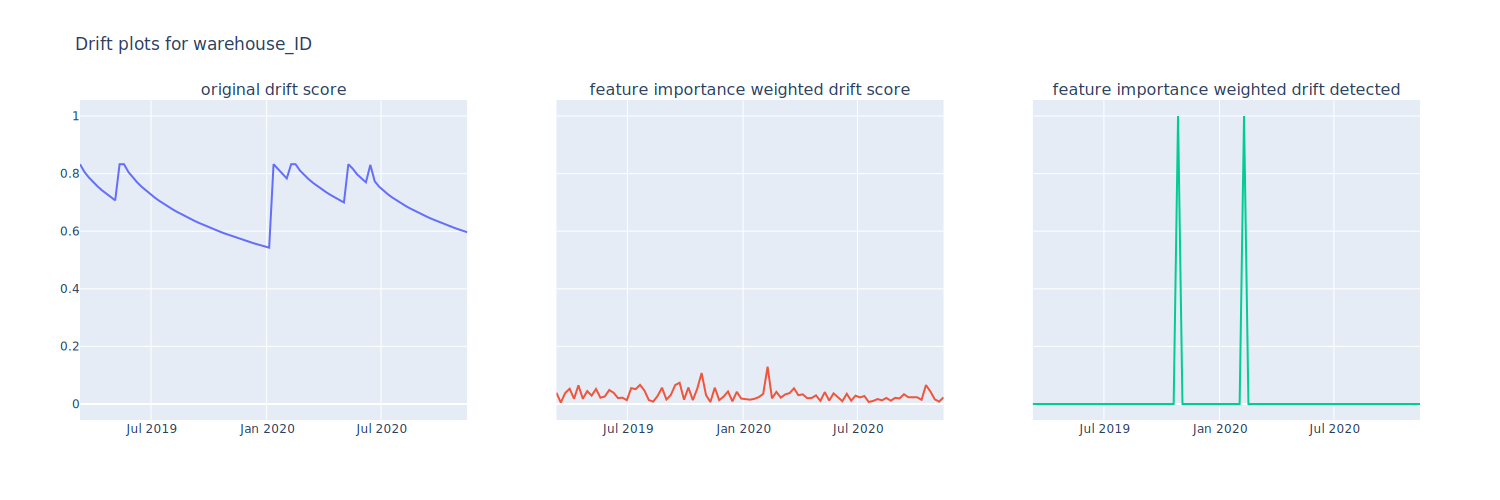

In [155]:
plot_drift_detection(drift_detected_experiment_results.iloc[1:], 'warehouse_ID')

#### Drift in product type

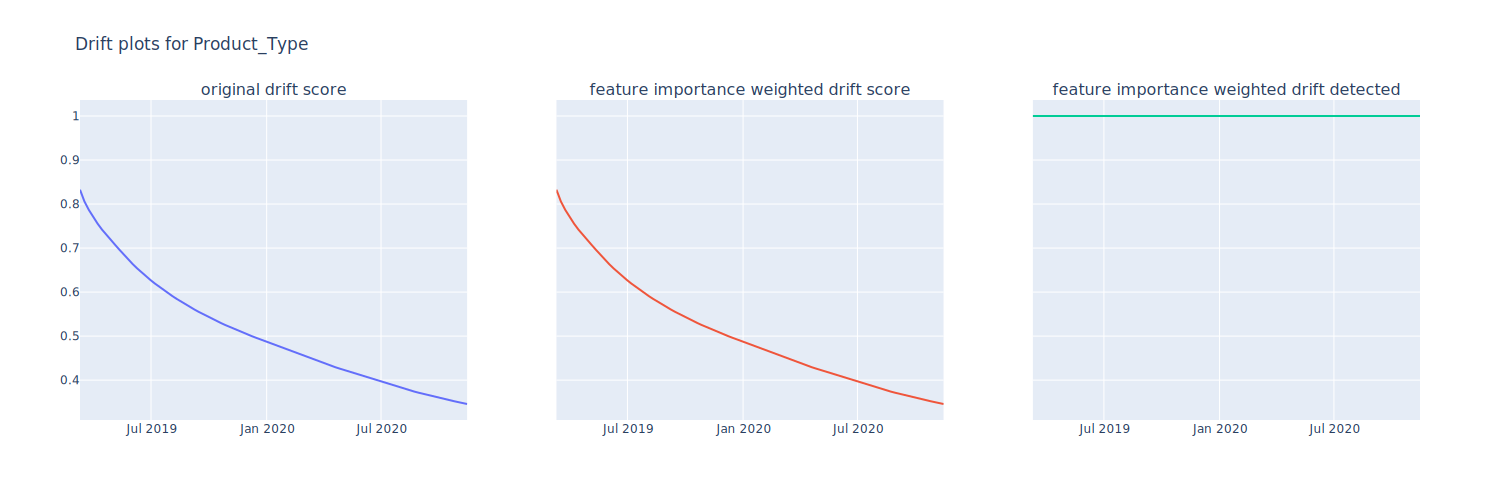

In [156]:
plot_drift_detection(drift_detected_experiment_results.iloc[1:], 'Product_Type')

#### Drift in covid cases per state

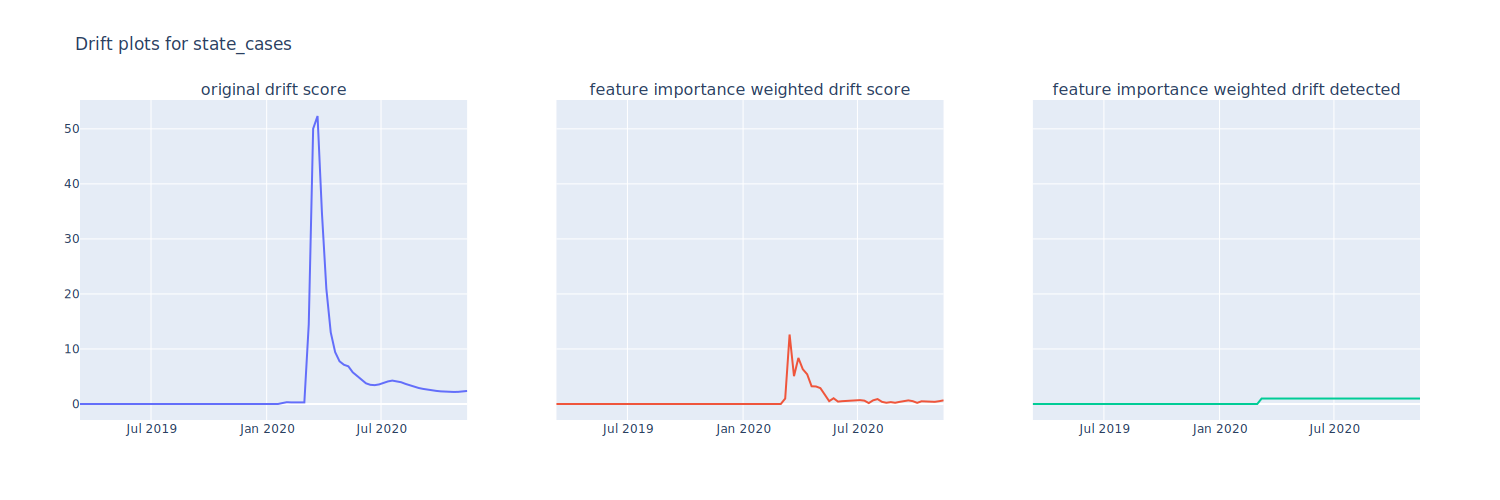

In [157]:
plot_drift_detection(drift_detected_experiment_results.iloc[1:], 'state_cases')

#### Drift in covid deaths per state

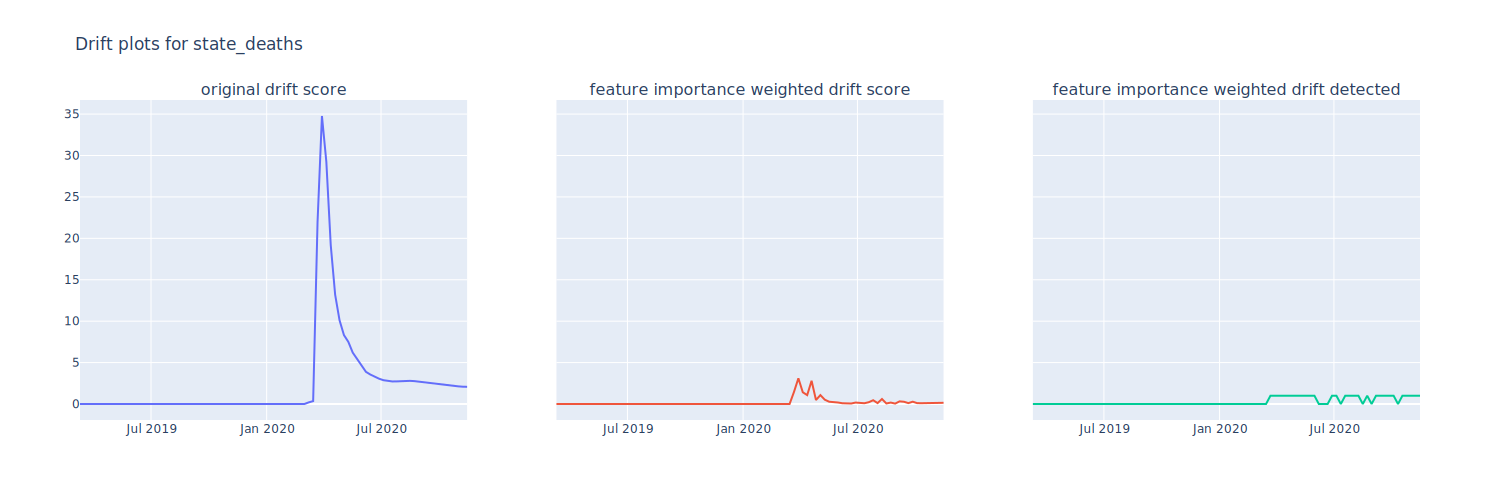

In [158]:
plot_drift_detection(drift_detected_experiment_results.iloc[1:], 'state_deaths')

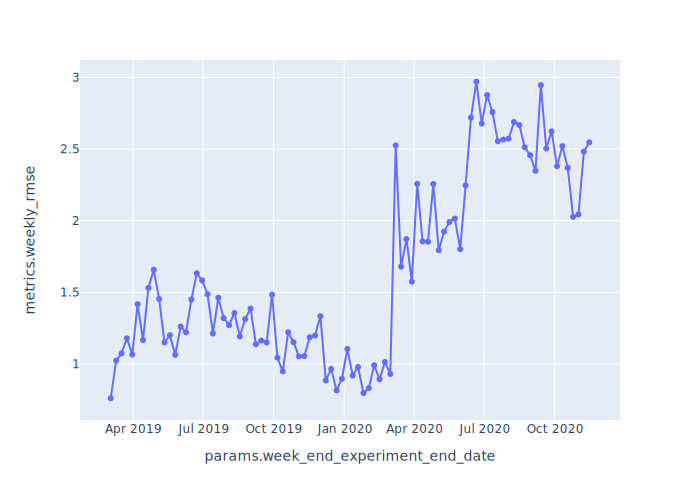

In [159]:
fig = px.line(expirement_results,  y='metrics.weekly_rmse', markers=True)
fig.show()